## Combining dataset

In [2]:
import pandas as pd

# Load CSV file
df_education = pd.read_csv("NPC Aggregated csvs/Education_Datasets (2011-2023).csv")

# Trim spaces from all string columns
df_education[df_education.select_dtypes("object").columns] = df_education.select_dtypes("object").map(lambda x: x.strip())

# Melt Male and Female columns into one 'Gender' and 'Graduates' column
df_education = pd.melt(df_education, id_vars=["Year", "Economic Sector", "Degree Type", "Academic Degree"], 
                    value_vars=["Male", "Female"], 
                    var_name="Gender", value_name="Graduates")

# Pivot Degree Type into separate columns (Bachelors, Diploma, etc.)
df_education = df_education.pivot_table(index=["Year", "Economic Sector", "Gender"],
                                 columns="Degree Type",
                                 values="Graduates",
                                 aggfunc="sum").reset_index()

# Ensure all degree columns exist
degree_columns = ['Bachelors', 'Diploma', 'Master', 'Doctorate', 'Pre-University Diploma']

# Drop the 'Degree Type' column (no longer needed after pivoting)
df_education = df_education[["Year", "Economic Sector", "Gender"] + degree_columns]
df_education['Gender'] = df_education['Gender'].replace({'M': 'Male', 'F': 'Female'})
df_education.rename(columns={"Economic Sector": "Economic activity"}, inplace=True)
df_education.fillna(0, inplace=True)
df_education.head(20)

# ========================================================

df_labour = pd.read_csv("NPC Aggregated csvs/Labour_dataset (2011-2023).csv")
df_labour['Gender'] = df_labour['Gender'].replace({'M': 'Male', 'F': 'Female'})

# Merge this combination DataFrame with the original data to fill missing combinations
df_full = pd.merge(df_labour, df_education, on=['Year', 'Economic activity', 'Gender'], how='left')
df_full.fillna(0, inplace=True)

df_full['Economically active population'] = pd.to_numeric(df_full['Economically active population'], downcast='integer', errors='coerce')

# Save the transformed data to a new CSV file
df_full.to_csv("Aggregated_labour_education (2011-2023).csv", index=False)

# Display the first rows
df_full.tail(10)


Year                                  Economic activity Gender  \
510  2023                 Financial and insurance activities   Male   
511  2023                             Real estate activities   Male   
512  2023  Professional, scientific and technical activities   Male   
513  2023      Administrative and support service activities   Male   
514  2023  Public administration and defence; compulsory ...   Male   
515  2023                                          Education   Male   
516  2023            Human health and social work activities   Male   
517  2023                 Arts, entertainment and recreation   Male   
518  2023                           Other service activities   Male   
519  2023  Activities of households as employers; undiffe...   Male   

     Economically active population  Monthly average wage  \
510                           18834                 30052   
511                           18733                 13776   
512                           27332                 16216   
513                          163897                  4701   
514                           88928                 32849   
515                           31492                 25789   
516                           54924                 22968   
517                            9750                 24522   
518                           11005                 11479   
519                           66195                  3115   

     Paid employment workers  Sector GDP  Bachelors  Diploma  Master  \
510                    18741     82943.0      269.0      0.0    14.0   
511                    18251     47344.0        0.0      0.0     0.0   
512                    26906     12015.5      237.0      0.0     9.0   
513                   163682     12015.5        0.0      0.0     0.0   
514                    88881     47751.0      143.0      0.0    12.0   
515                    31029     12082.0       44.0     17.0     8.0   
516                    54571     13929.0       41.0      0.0     7.0   
517                     9583      3996.5      130.0      0.0     0.0   
518                    11005      3996.5        0.0      0.0     0.0   
519                    66195      4046.0        0.0      0.0     0.0   

     Doctorate  Pre-University Diploma  
510        0.0                     0.0  
511        0.0                     0.0  
512        4.0                     0.0  
513        0.0                     0.0  
514        3.0                    11.0  
515        4.0                   343.0  
516        1.0                     0.0  
517        0.0                     0.0  
518        0.0                     0.0  
519        0.0                     0.0

## Autogluon

In [3]:
# %pip install autogluon
# %pip install keras==2.11.0

In [4]:
df = pd.read_csv("Aggregated_labour_education (2011-2023).csv")
df.info()
df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            520 non-null    int64  
 1   Economic activity               520 non-null    object 
 2   Gender                          520 non-null    object 
 3   Economically active population  520 non-null    int64  
 4   Monthly average wage            520 non-null    int64  
 5   Paid employment workers         520 non-null    int64  
 6   Sector GDP                      520 non-null    float64
 7   Bachelors                       520 non-null    float64
 8   Diploma                         520 non-null    float64
 9   Master                          520 non-null    float64
 10  Doctorate                       520 non-null    float64
 11  Pre-University Diploma          520 non-null    float64
dtypes: float64(6), int64(4), object(2)
m

Index(['Year', 'Economic activity', 'Gender', 'Economically active population',
       'Monthly average wage', 'Paid employment workers', 'Sector GDP',
       'Bachelors', 'Diploma', 'Master', 'Doctorate',
       'Pre-University Diploma'],
      dtype='object')

### all three prediction

In [5]:
import pandas as pd
from autogluon.timeseries import TimeSeriesPredictor

# Load Data
df = pd.read_csv("Aggregated_labour_education (2011-2023).csv")

# Fill missing values
df['Economically active population'].fillna(df['Economically active population'].mean(), inplace=True)

# Create unique ID for Sector-Gender pairs
df['ID'] = df['Economic activity'] + '_' + df['Gender']

# Rename Year to timestamp
df = df.rename(columns={'Year': 'timestamp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y')

# List of targets to predict
targets = ['Monthly average wage', 'Economically active population', 'Paid employment workers']

# Dictionary to store forecasts
forecast_dfs = []

# Loop through each target and make predictions
for target in targets:
    # Prepare Data
    ts_df = df[['ID', 'timestamp', 'Sector GDP', target,
       'Bachelors', 'Diploma', 'Master', 'Doctorate', 'Pre-University Diploma']].copy()

    # Convert to TimeSeriesDataFrame
    from autogluon.timeseries import TimeSeriesDataFrame
    ts_data = TimeSeriesDataFrame.from_data_frame(ts_df, id_column='ID', timestamp_column='timestamp')

    # Initialize Predictor
    predictor = TimeSeriesPredictor(
        prediction_length=4,  # Predict 2024-2027
        target=target
    )

    # Train model
    predictor.fit(train_data=ts_data)

    # Make Predictions
    forecast = predictor.predict(ts_data)

    # Rename columns to include target info
    forecast = forecast.reset_index()
    forecast = forecast.rename(columns={'mean': f'{target}'})

    # Keep necessary columns
    forecast = forecast[['item_id', 'timestamp', f'{target}']]

    forecast_dfs.append(forecast)

# Merge all forecasts
from functools import reduce

# Merge dataframes on item_id and timestamp
final_forecast = reduce(lambda left, right: pd.merge(left, right, on=['item_id', 'timestamp']), forecast_dfs)

# Split item_id back to Economic activity and Gender
final_forecast[['Economic activity', 'Gender']] = final_forecast['item_id'].str.split('_', expand=True)
final_forecast['Year'] = final_forecast['timestamp'].dt.year
final_forecast['Year'] = pd.to_datetime(final_forecast.Year, format='%Y')
final_forecast["Economically active population"] = final_forecast["Economically active population"].round(0).astype(int)
final_forecast["Paid employment workers"] = final_forecast["Paid employment workers"].round(0).astype(int)

# Rearrange columns
final_forecast = final_forecast[['Year', 'Economic activity', 'Gender', 
                                 'Economically active population', 
                                 'Monthly average wage', 
                                 'Paid employment workers']]

# Save to CSV
final_forecast.to_csv('Forecasted_wage_active_wage (2024_2027).csv', index=False)


print("✅ Full forecast saved as 'Forecasted_wage_active_wage (2024_2027).csv'.")
print(final_forecast.head())

c:\Users\Joy Anne\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Joy Anne\AppData\Local\Temp\ipykernel_5896\2065862750.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Economically active population'].fillna(df['Economically active population'].mean(), inplace=True)
Beginning AutoGluon training...
A

✅ Full forecast saved as 'Forecasted_wage_active_wage (2024_2027).csv'.
        Year                  Economic activity  Gender  \
0 2024-01-01  Agriculture, forestry and fishing  Female   
1 2025-01-01  Agriculture, forestry and fishing  Female   
2 2026-01-01  Agriculture, forestry and fishing  Female   
3 2027-01-01  Agriculture, forestry and fishing  Female   
4 2024-01-01               Mining and quarrying  Female   

   Economically active population  Monthly average wage  \
0                               2            157.561219   
1                               8            109.585185   
2                               8             67.057407   
3                               8             52.482666   
4                            5404          22512.057444   

   Paid employment workers  
0                        2  
1                        9  
2                        8  
3                        9  
4                     5386  


In [24]:
predictor.info()

{'path': 'c:\\Users\\Joy Anne\\Desktop\\NPC_LabourLensQ\\Notebook\\AutogluonModels\\ag-20250312_205353',
 'version': '1.2',
 'time_fit_training': 315.36628007888794,
 'time_limit': None,
 'best_model': 'WeightedEnsemble',
 'best_model_score_val': -0.22325574163036066,
 'num_models_trained': 11,
 'model_info': {'SeasonalNaive': {'name': 'SeasonalNaive',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric': WQL,
   'fit_time': 0.01051020622253418,
   'predict_time': 0.05099797248840332,
   'freq': 'YS-JAN',
   'prediction_length': 4,
   'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
   'val_score': -0.2767938096847368,
   'hyperparameters': {},
   'info_per_val_window': [{'window_index': 0,
     'refit_this_window': True,
     'fit_time': 0.004503488540649414,
     'val_score': -0.2767938096847368,
     'predict_time': 0.05099797248840332}]},
  'RecursiveTabular': {'name': 'RecursiveTabular',
   'model_type': 'MultiWindowBacktestingModel',
   'eval_metric':

In [16]:
predictor.leaderboard(extra_info=True)

model  score_val  pred_time_val  fit_time_marginal  \
0            WeightedEnsemble  -0.223256       0.199857           1.002360   
1                    PatchTST  -0.228104       0.034070          23.485626   
2                        TiDE  -0.259937       0.055065         132.912245   
3                        NPTS  -0.263540       0.053355           0.015528   
4                     AutoETS  -0.268931       0.039874           0.011011   
5               DirectTabular  -0.274929       0.255512          12.983039   
6               SeasonalNaive  -0.276794       0.050998           0.010510   
7   TemporalFusionTransformer  -0.284021       0.040562          97.315613   
8                      DeepAR  -0.316540       0.060111          45.865463   
9       DynamicOptimizedTheta  -0.337532       0.052025           0.012384   
10           RecursiveTabular  -0.368235       0.114789           0.639160   

    fit_order                                    hyperparameters  
0          11                                                 {}  
1           9                                                 {}  
2          10  {'encoder_hidden_dim': 256, 'decoder_hidden_di...  
3           4                                                 {}  
4           6                                                 {}  
5           3                                                 {}  
6           1                                                 {}  
7           7                                                 {}  
8           8                                                 {}  
9           5                                                 {}  
10          2                                                 {}

In [27]:
final_forecast

Year                                  Economic activity  Gender  \
0   2024-01-01                  Agriculture, forestry and fishing  Female   
1   2025-01-01                  Agriculture, forestry and fishing  Female   
2   2026-01-01                  Agriculture, forestry and fishing  Female   
3   2027-01-01                  Agriculture, forestry and fishing  Female   
4   2024-01-01                               Mining and quarrying  Female   
..         ...                                                ...     ...   
155 2027-01-01                           Other service activities    Male   
156 2024-01-01  Activities of households as employers; undiffe...    Male   
157 2025-01-01  Activities of households as employers; undiffe...    Male   
158 2026-01-01  Activities of households as employers; undiffe...    Male   
159 2027-01-01  Activities of households as employers; undiffe...    Male   

     Economically active population  Monthly average wage  \
0                                 2            148.059613   
1                                 8            101.589398   
2                                 8             76.808206   
3                                 8             51.907976   
4                              5391          22665.106771   
..                              ...                   ...   
155                           12026          11637.775092   
156                           65889           3042.561881   
157                           81374           3041.997906   
158                           70725           3068.429576   
159                           65270           3091.743204   

     Paid employment workers  
0                          2  
1                          9  
2                          8  
3                          9  
4                       5386  
..                       ...  
155                    12279  
156                    65123  
157                    81280  
158                    71007  
159                    65074  

[160 rows x 6 columns]

### Plotting prediction vs historical

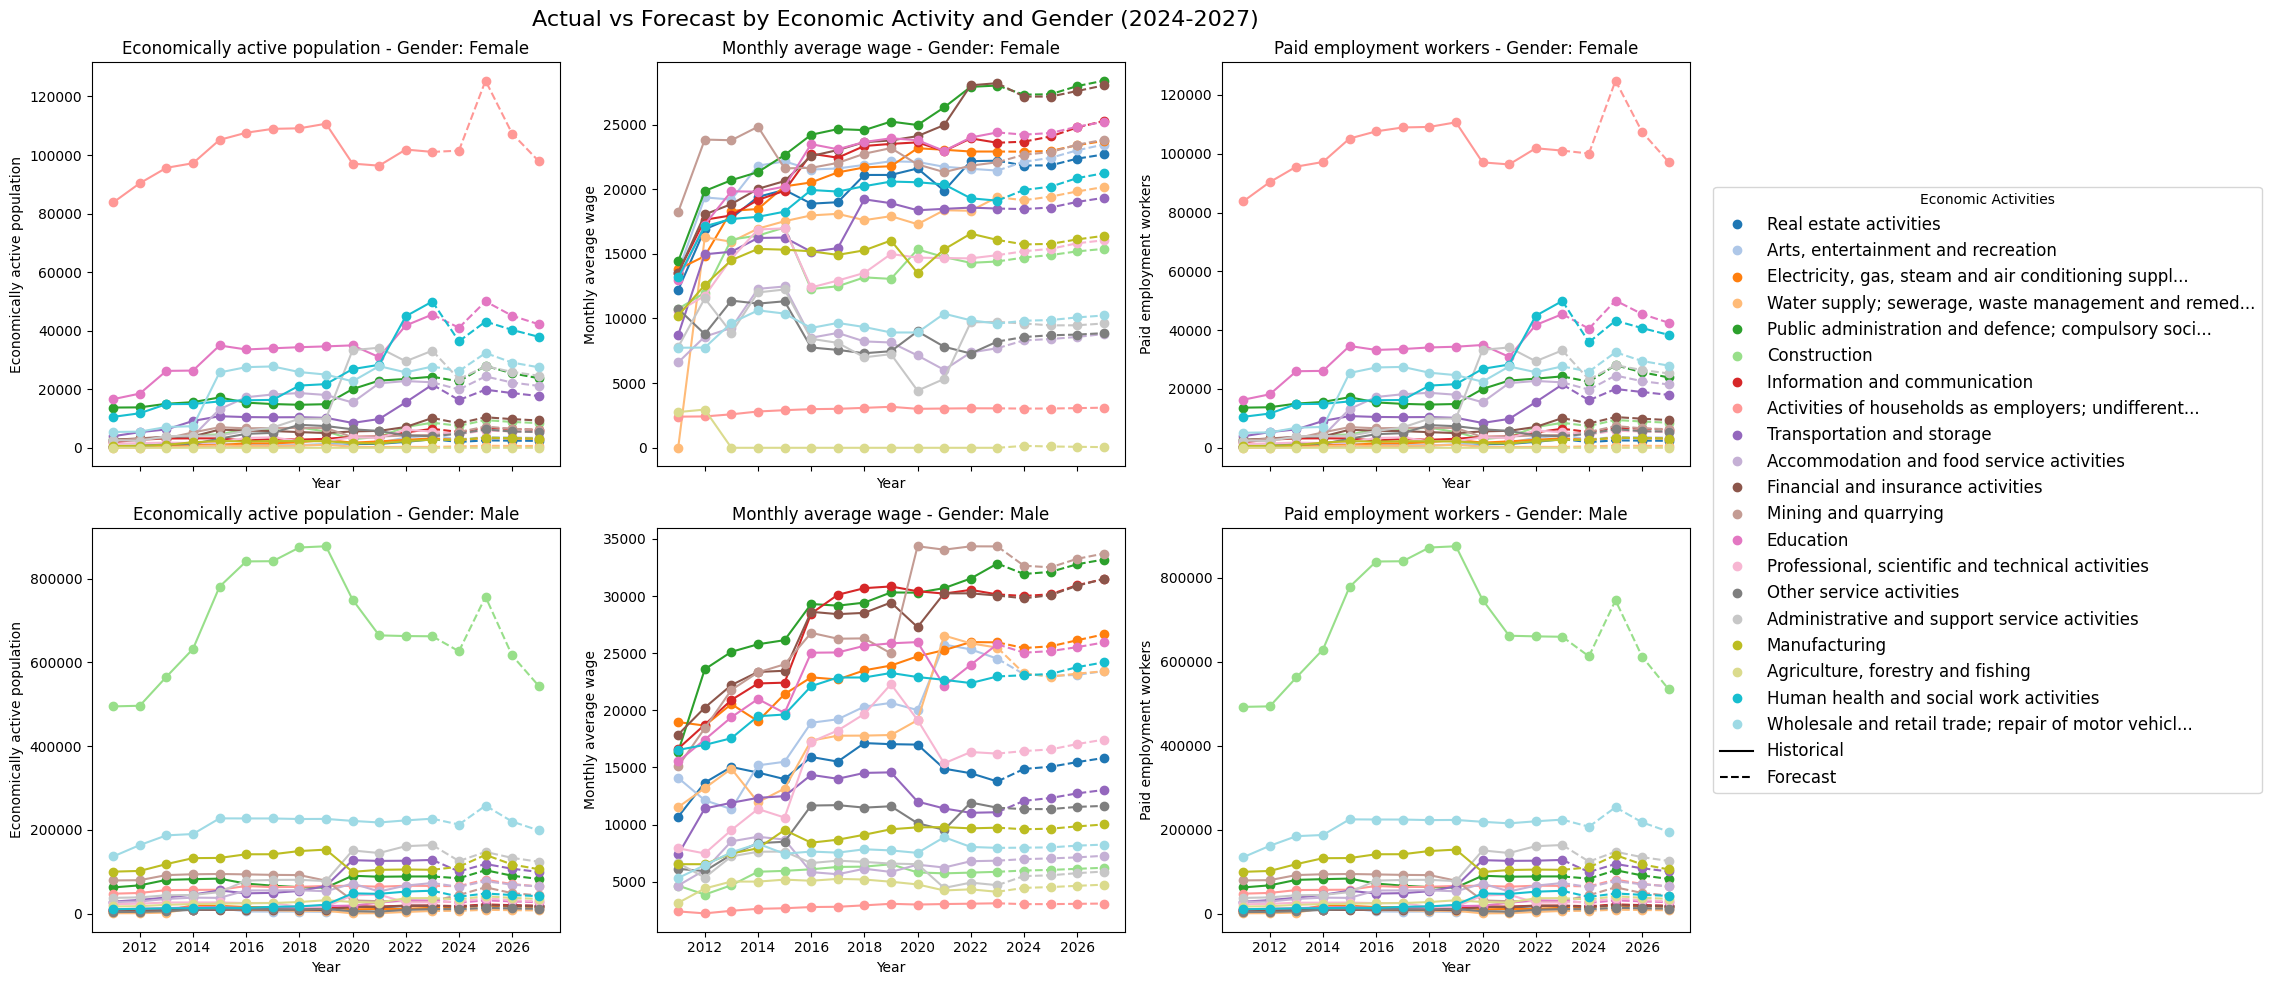

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load historical and predicted datasets
historical_data = pd.read_csv('Aggregated_labour_education (2011-2023).csv')  # Replace with your historical dataset path
predicted_data = pd.read_csv('Forecasted_wage_active_wage (2024_2027).csv')  # Replace with your predicted dataset path
predicted_data['Year'] = predicted_data['Year'].str[:4].astype(int)

# List of targets for plotting
targets = ['Economically active population', 'Monthly average wage', 'Paid employment workers']

# Combine unique Economic activities from both datasets
economic_activities_historical = historical_data['Economic activity'].unique()
economic_activities_predicted = predicted_data['Economic activity'].unique()
all_economic_activities = list(set(economic_activities_historical) | set(economic_activities_predicted))

# Get unique Genders
genders = historical_data['Gender'].unique()

# Set up color mapping for all sectors
color_palette = plt.cm.tab20.colors  # Extended color palette for more sectors
color_map = {activity: color_palette[i % len(color_palette)] for i, activity in enumerate(all_economic_activities)}

# Set up the subplot grid (2 rows for genders, 3 columns for each prediction)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10), sharex=True)
fig.suptitle('Actual vs Forecast by Economic Activity and Gender (2024-2027)', fontsize=16)

# Plot data for each gender and target
for i, gender in enumerate(genders):
    historical_gender_df = historical_data[historical_data['Gender'] == gender]
    predicted_gender_df = predicted_data[predicted_data['Gender'] == gender]

    for j, target in enumerate(targets):
        ax = axes[i, j]
        
        for activity in all_economic_activities:
            # Filter historical and predicted data for the specific sector and gender
            historical_df = historical_gender_df[historical_gender_df['Economic activity'] == activity]
            predicted_df = predicted_gender_df[predicted_gender_df['Economic activity'] == activity]

            # Fallback color if activity is missing in color_map
            color = color_map.get(activity, 'gray')

            # Actual data plot (solid line)
            if not historical_df.empty:
                ax.plot(historical_df['Year'], historical_df[target], label=f'Actual - {activity}',
                        marker='o', color=color, linestyle='-')

            # Forecast data plot (dashed line)
            if not predicted_df.empty:
                ax.plot(predicted_df['Year'], predicted_df[target], label=f'Forecast - {activity}',
                        marker='o', color=color, linestyle='--')
                
            # Connect the forcast and historical
            connection_df = pd.concat([historical_df.tail(1), predicted_df.head(1)])
            ax.plot(connection_df['Year'], connection_df[target], linestyle='--', color=color)

        ax.set_title(f"{target} - Gender: {gender}")
        ax.set_xlabel('Year')
        ax.set_ylabel(target)

import matplotlib.lines as mlines

# Function to truncate long names
def truncate_name(name, max_length=50):
    return name if len(name) <= max_length else name[:max_length] + "..."

# Create custom legend handles with truncated names
legend_handles = []
for activity, color in color_map.items():
    truncated_activity = truncate_name(activity)
    historical_line = mlines.Line2D([], [], color=color, marker='o', linestyle='', label=truncated_activity)
    predicted_line = mlines.Line2D([], [], color=color, marker='o', linestyle='')
    legend_handles.append(historical_line)

# Add separate legend entries for historical vs predicted markers
historical_marker = mlines.Line2D([], [], color='black', marker='', linestyle='-', label='Historical')
predicted_marker = mlines.Line2D([], [], color='black', marker='', linestyle='--', label='Forecast')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.95, 1])

# Add a legend outside the plots on the right
fig.legend(handles=legend_handles + [historical_marker, predicted_marker], 
           loc='center left', bbox_to_anchor=(0.95, 0.5), title="Economic Activities", fontsize=12)

plt.savefig("Actual vs Forecast by Economic Activity and Gender (2024-2027).png")
plt.show()

# Saving the Combined dataset

In [3]:
import pandas as pd

# Load the datasets
historical_data = pd.read_csv('Aggregated_labour_education (2011-2023).csv')  
predicted_data = pd.read_csv('Forecasted_wage_active_wage (2024_2027).csv')

# Ensure 'Year' column is in integer format for predicted_data
predicted_data['Year'] = predicted_data['Year'].astype(str).str[:4].astype(int)

# Concatenate the datasets
combined_data = pd.concat([historical_data, predicted_data], ignore_index=True)
combined_data.fillna(0, inplace=True)

combined_data['Year'] = pd.to_datetime(combined_data.Year, format='%Y')
combined_data["Economically active population"] = combined_data["Economically active population"].round(0).astype(int)
combined_data["Paid employment workers"] = combined_data["Paid employment workers"].round(0).astype(int)
combined_data["Bachelors"] = combined_data["Bachelors"].round(0).astype(int)
combined_data["Diploma"] = combined_data["Diploma"].round(0).astype(int)
combined_data["Master"] = combined_data["Master"].round(0).astype(int)
combined_data["Doctorate"] = combined_data["Doctorate"].round(0).astype(int)
combined_data["Pre-University Diploma"] = combined_data["Pre-University Diploma"].round(0).astype(int)

# Save the combined dataset (optional)
combined_data.to_csv('Combined_historical_predictions_data.csv', index=False)

# Display the first few rows
combined_data

Year                                  Economic activity  Gender  \
0   2011-01-01                  Agriculture, forestry and fishing  Female   
1   2011-01-01                               Mining and quarrying  Female   
2   2011-01-01                                      Manufacturing  Female   
3   2011-01-01  Electricity, gas, steam and air conditioning s...  Female   
4   2011-01-01  Water supply; sewerage, waste management and r...  Female   
..         ...                                                ...     ...   
675 2027-01-01                           Other service activities    Male   
676 2024-01-01  Activities of households as employers; undiffe...    Male   
677 2025-01-01  Activities of households as employers; undiffe...    Male   
678 2026-01-01  Activities of households as employers; undiffe...    Male   
679 2027-01-01  Activities of households as employers; undiffe...    Male   

     Economically active population  Monthly average wage  \
0                                46           2765.000000   
1                              2487          18237.000000   
2                               600          10217.000000   
3                               390          13807.000000   
4                                 0              0.000000   
..                              ...                   ...   
675                           12026          11637.775092   
676                           65889           3042.561881   
677                           81374           3041.997906   
678                           70725           3068.429576   
679                           65270           3091.743204   

     Paid employment workers  Sector GDP  Bachelors  Diploma  Master  \
0                         46       590.0          0        0       0   
1                       2441    359227.0          0        0       0   
2                        600     57789.0          0        0       0   
3                        390       795.0          0        0       0   
4                          0       795.0          0        0       0   
..                       ...         ...        ...      ...     ...   
675                    12279         0.0          0        0       0   
676                    65123         0.0          0        0       0   
677                    81280         0.0          0        0       0   
678                    71007         0.0          0        0       0   
679                    65074         0.0          0        0       0   

     Doctorate  Pre-University Diploma  
0            0                       0  
1            0                       0  
2            0                       0  
3            0                       0  
4            0                       0  
..         ...                     ...  
675          0                       0  
676          0                       0  
677          0                       0  
678          0                       0  
679          0                       0  

[680 rows x 12 columns]

# Saving the Salary Difference dataset

In [ ]:
import pandas as pd
salary_gap = pd.read_csv('Combined_historical_predictions_data.csv')  
salary_gap = salary_gap.pivot(index=["Year", "Economic activity"], columns="Gender", values=["Monthly average wage", "Paid employment workers"])

# Flatten MultiIndex Columns
salary_gap.columns = ["Female Salary", "Male Salary", "Female Paid Workers", "Male Paid Workers"]
salary_gap = salary_gap.reset_index()

salary_gap["Female Salary"] = salary_gap["Female Salary"].round(2)
salary_gap["Male Salary"] = salary_gap["Male Salary"].round(2)
salary_gap["Female Paid Workers"] = salary_gap["Female Paid Workers"].round(0).astype(int)
salary_gap["Male Paid Workers"] = salary_gap["Male Paid Workers"].round(0).astype(int)
salary_gap["Salary gap"] = salary_gap["Male Salary"] - salary_gap["Female Salary"]
salary_gap["Women are paid"] = salary_gap.apply(lambda row: "less" if row["Male Salary"] > row["Female Salary"] else "more", axis=1)
salary_gap["Absolute gap"] = abs(salary_gap["Salary gap"])

salary_gap.to_csv('Salary Gap (2024_2027).csv', index=False)


print("✅ Full forecast saved as 'Salary Gap (2024_2027).csv'.")
print(salary_gap.head())

✅ Full forecast saved as 'Salary gap (2024_2027).csv'.
         Year                                  Economic activity  \
0  2011-01-01          Accommodation and food service activities   
1  2011-01-01  Activities of households as employers; undiffe...   
2  2011-01-01      Administrative and support service activities   
3  2011-01-01                  Agriculture, forestry and fishing   
4  2011-01-01                 Arts, entertainment and recreation   

   Female Salary  Male Salary  Female Paid Workers  Male Paid Workers  \
0         6602.0       4669.0                 2548              27788   
1         2409.0       2403.0                83792              47815   
2         7798.0       6640.0                 2444              37629   
3         2765.0       3153.0                   46              17047   
4        13657.0      14089.0                  742               3883   

   Salary gap Women are paid  Absolute gap  
0     -1933.0           more        1933.0  
1      

## SMA 

### population

Loaded Data:
   timestamp                                  Economic activity  Gender  \
0 2011-01-01                  Agriculture, forestry and fishing  Female   
1 2011-01-01                               Mining and quarrying  Female   
2 2011-01-01                                      Manufacturing  Female   
3 2011-01-01  Electricity, gas, steam and air conditioning s...  Female   
4 2011-01-01  Water supply; sewerage, waste management and r...  Female   

   Economically active population  Monthly average wage  \
0                              46                  2765   
1                            2487                 18237   
2                             600                 10217   
3                             390                 13807   
4                               0                     0   

   Paid employment workers  Sector GDP  Bachelors  Diploma  Master  Doctorate  \
0                       46       590.0        0.0      0.0     0.0        0.0   
1                  

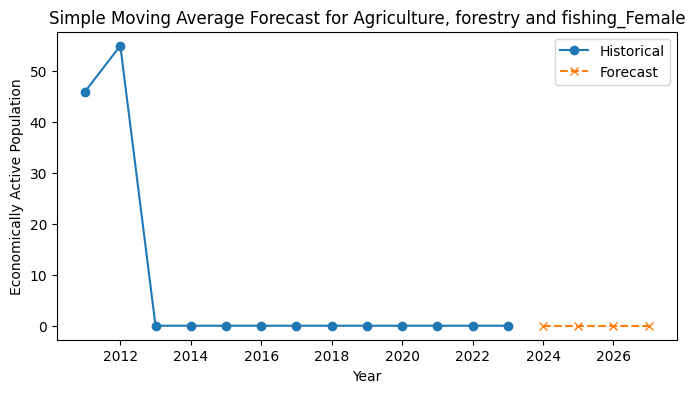

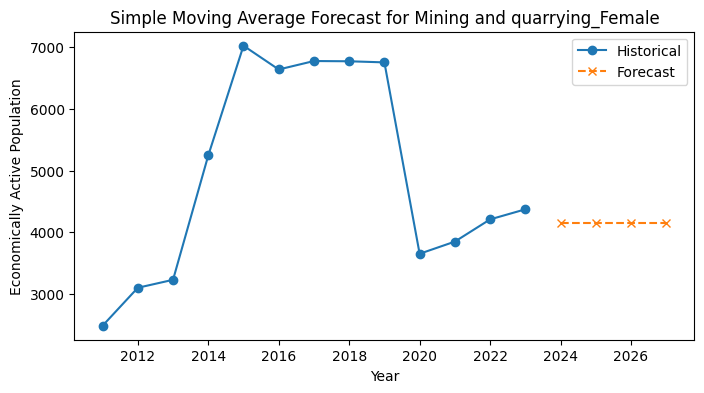

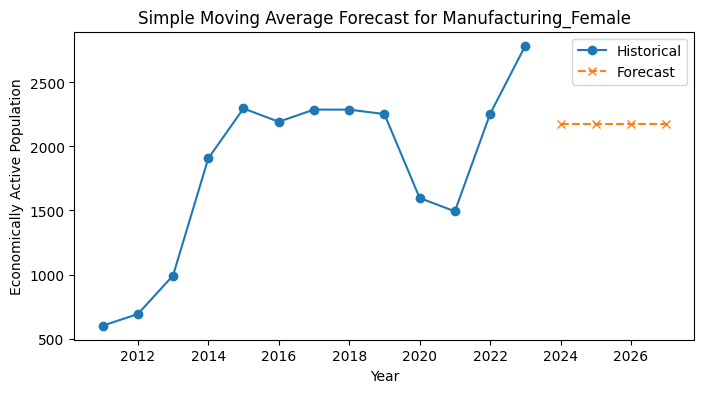

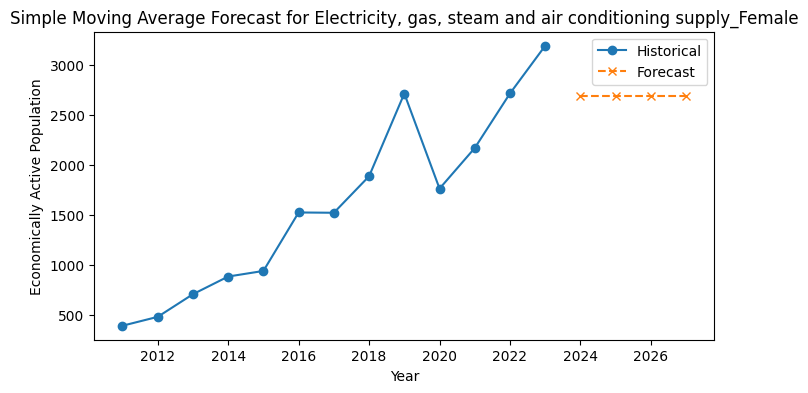

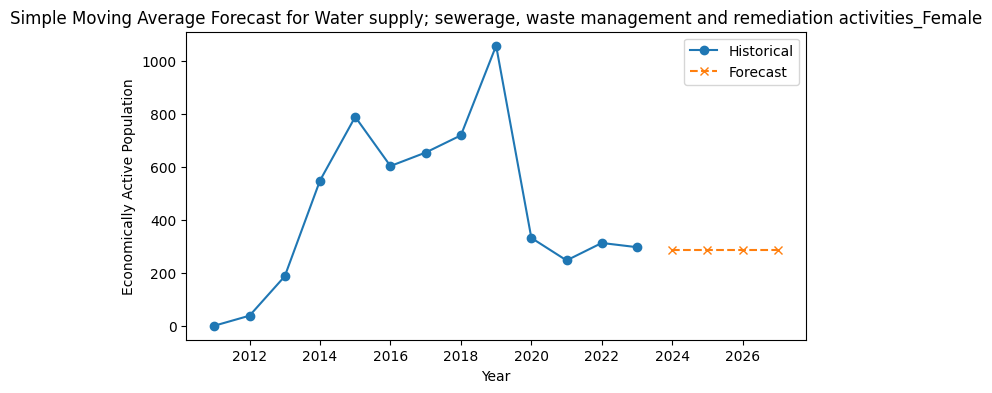

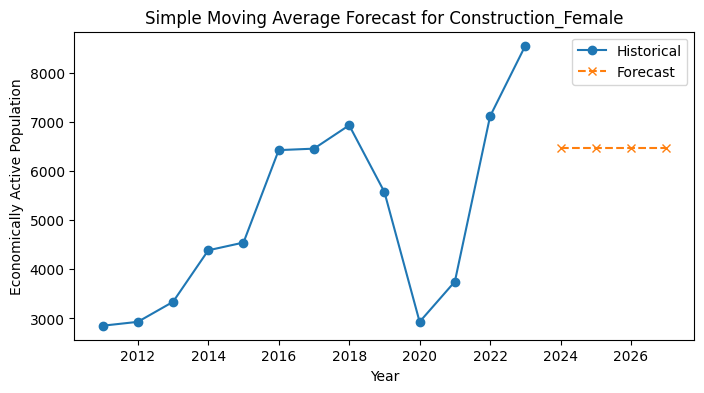

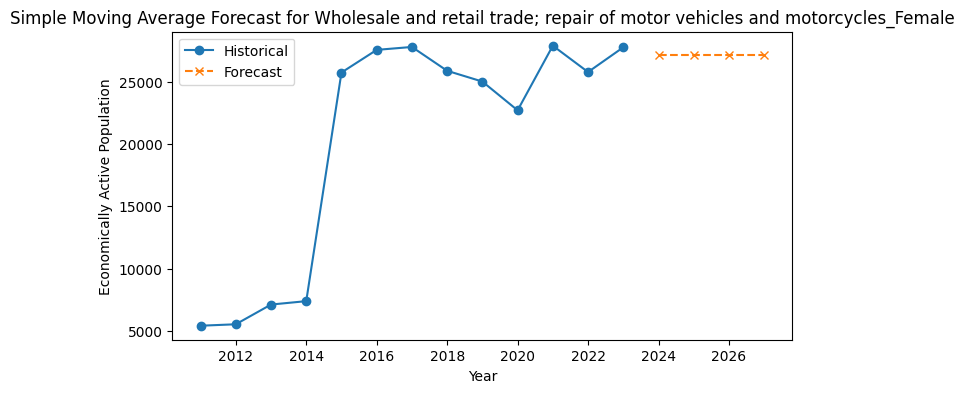

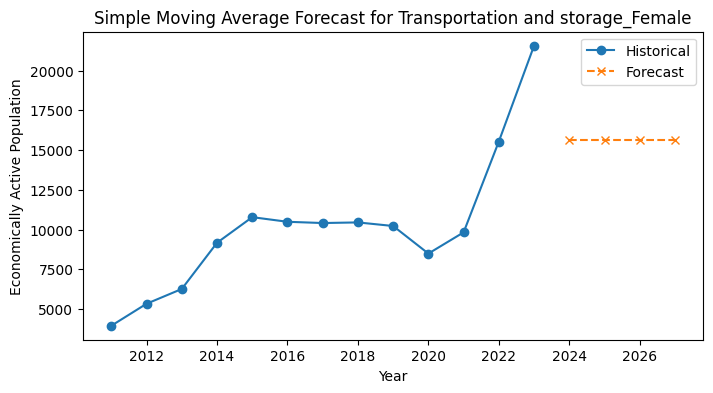

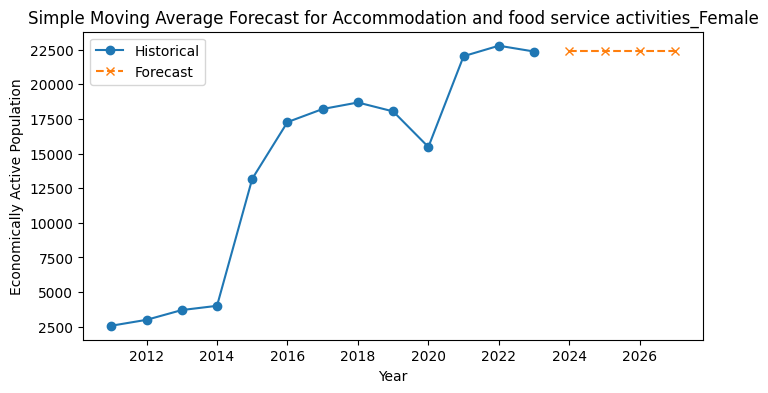

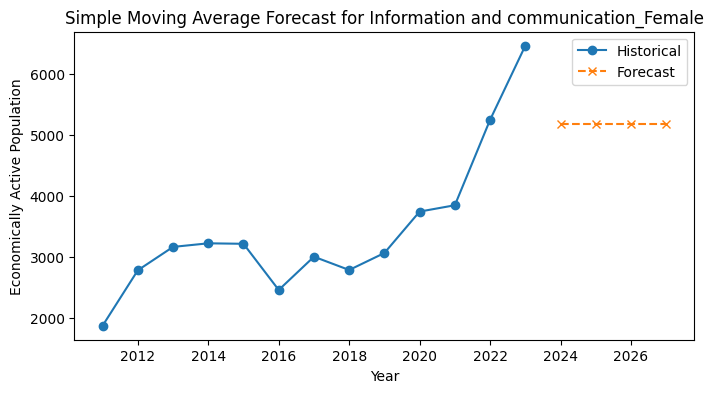

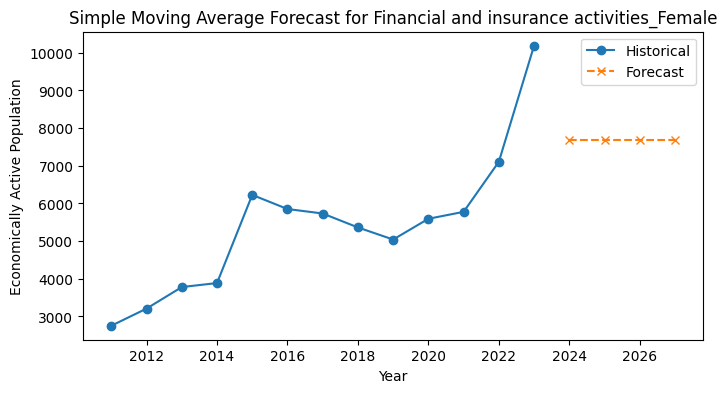

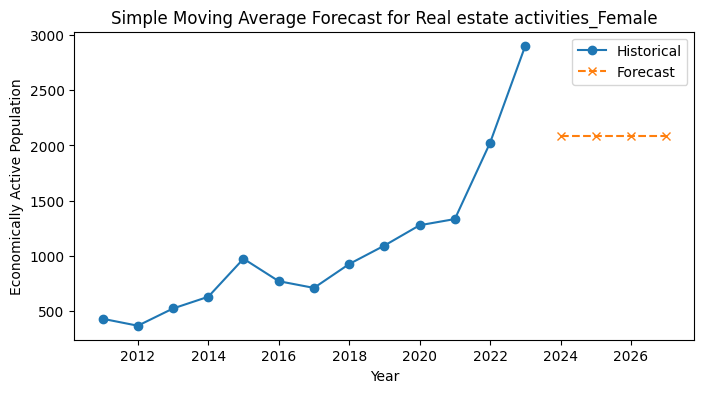

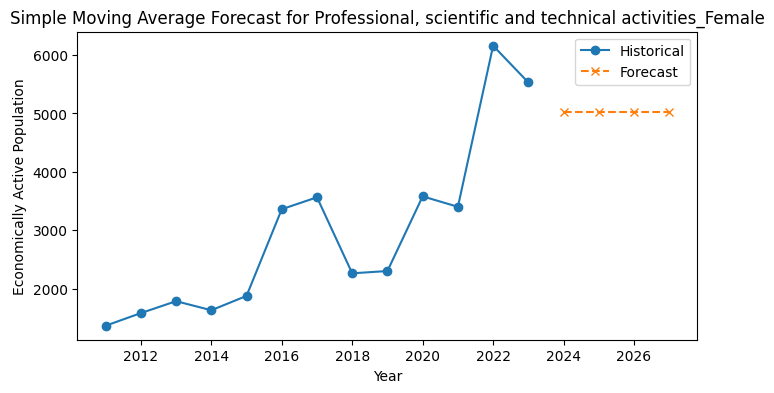

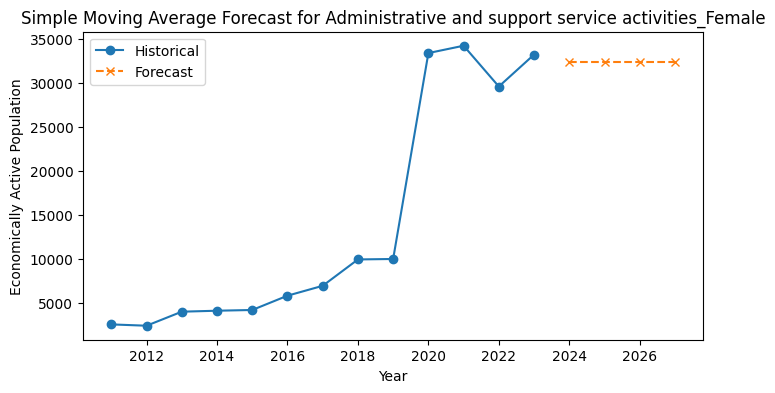

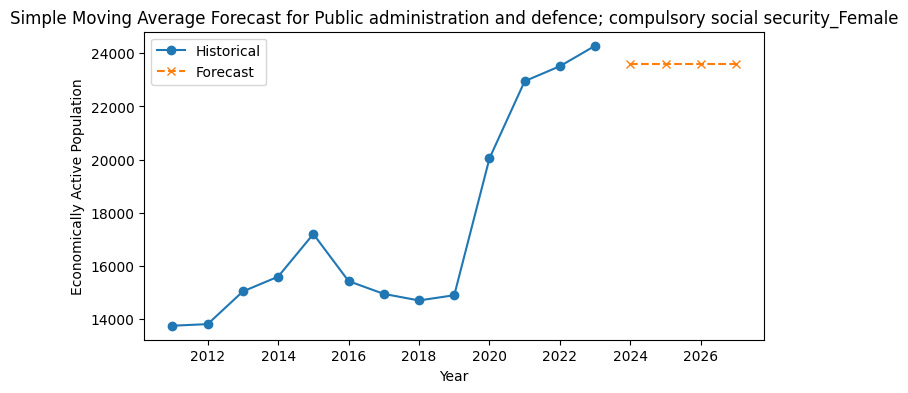

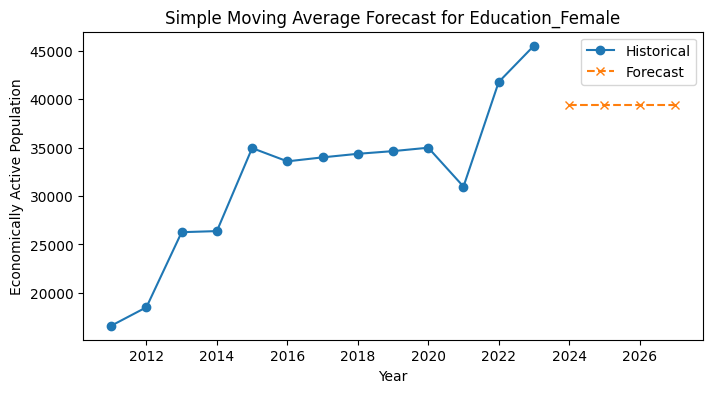

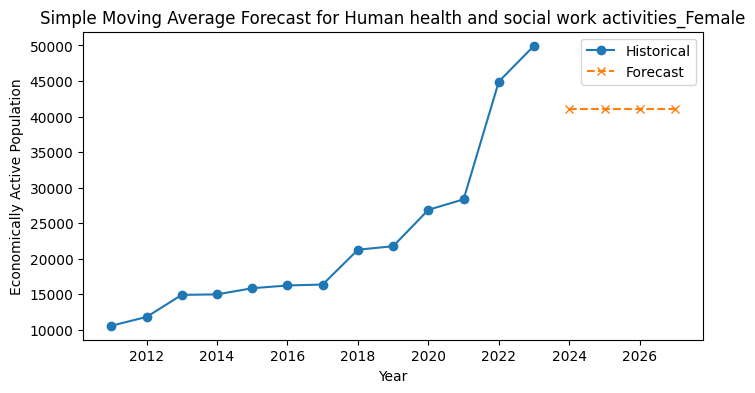

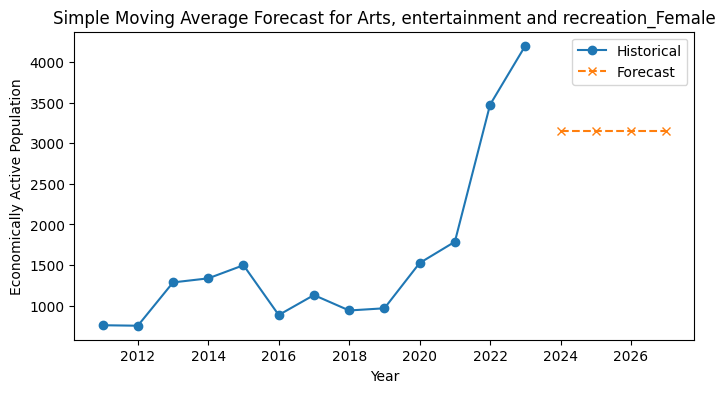

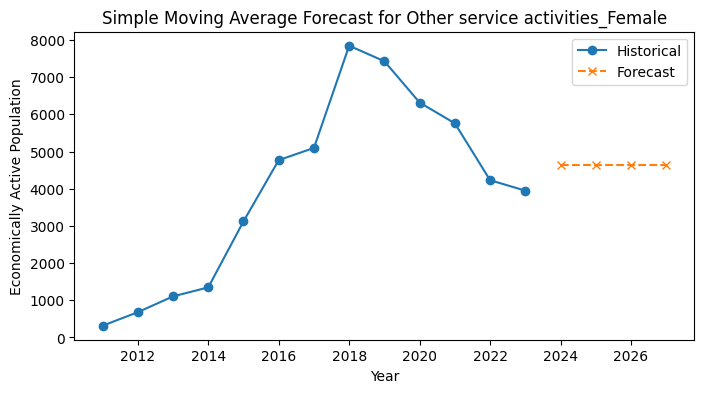

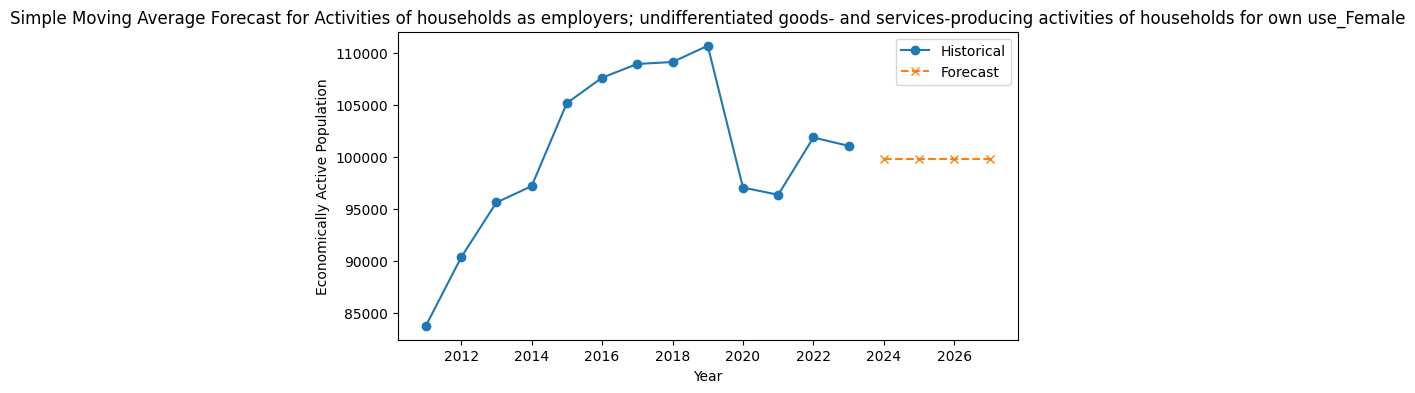

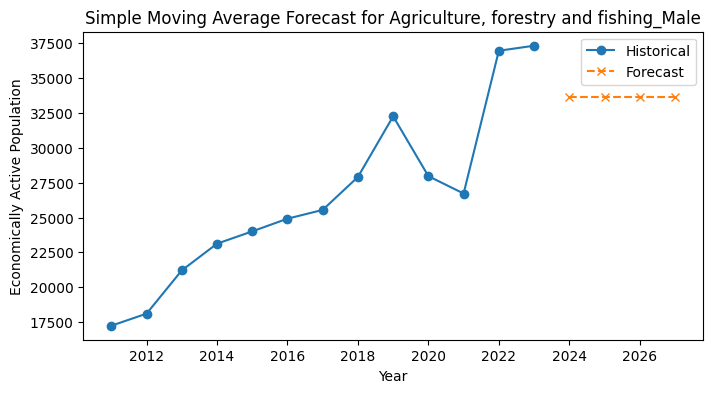

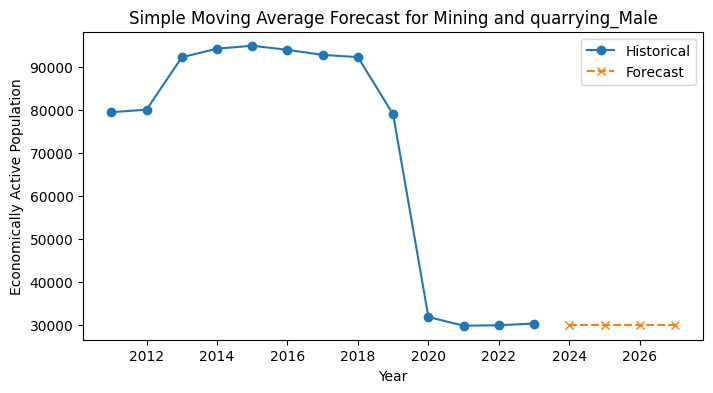

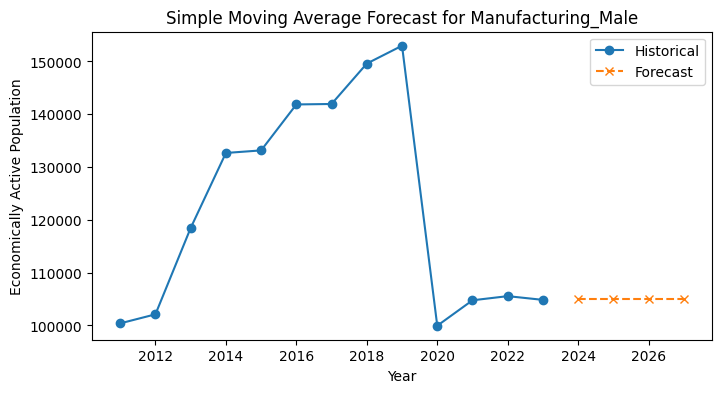

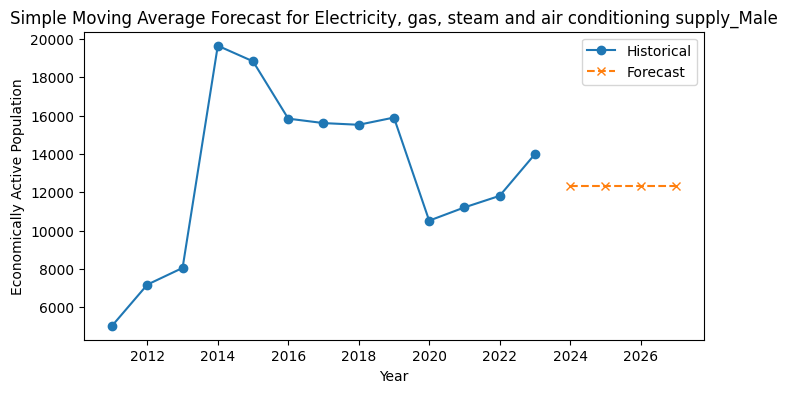

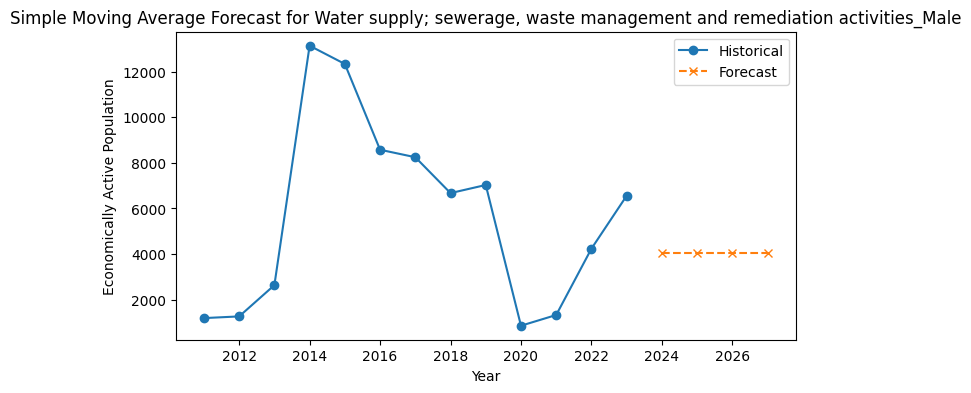

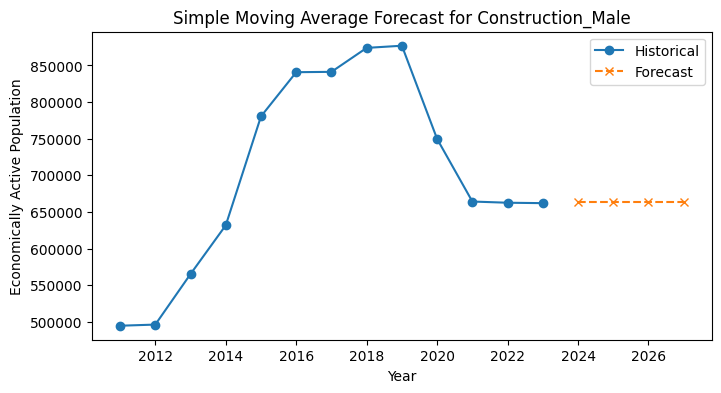

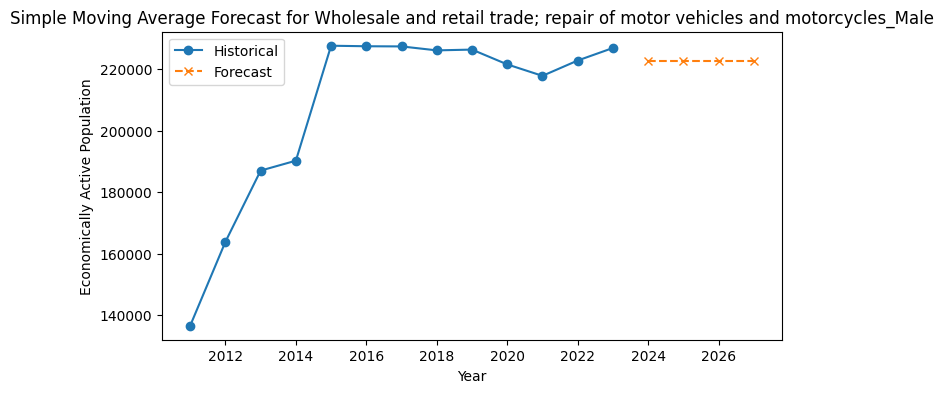

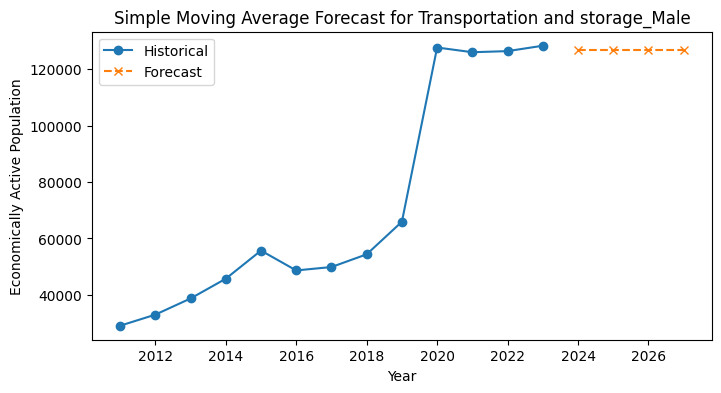

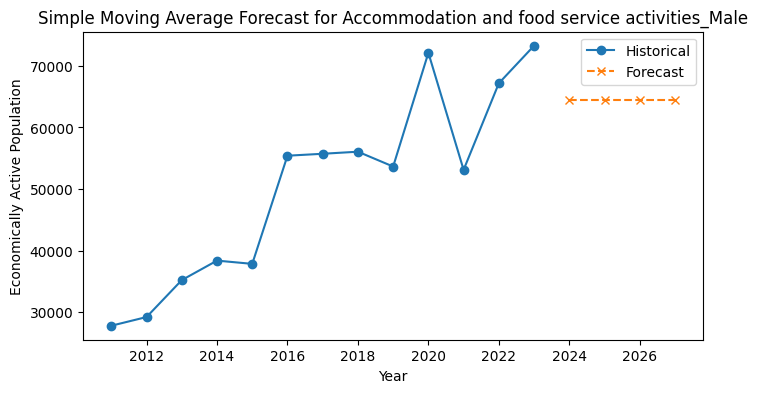

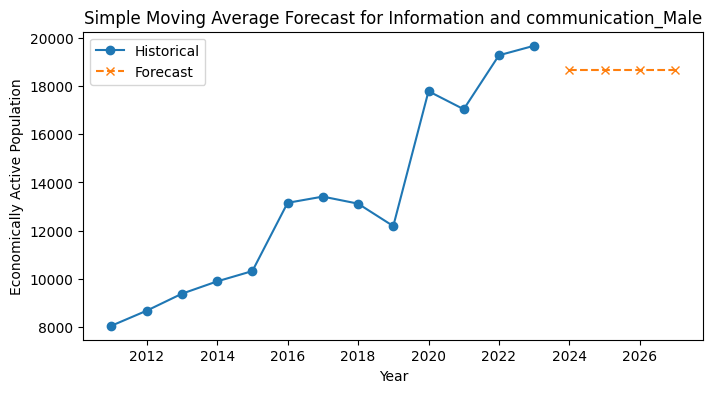

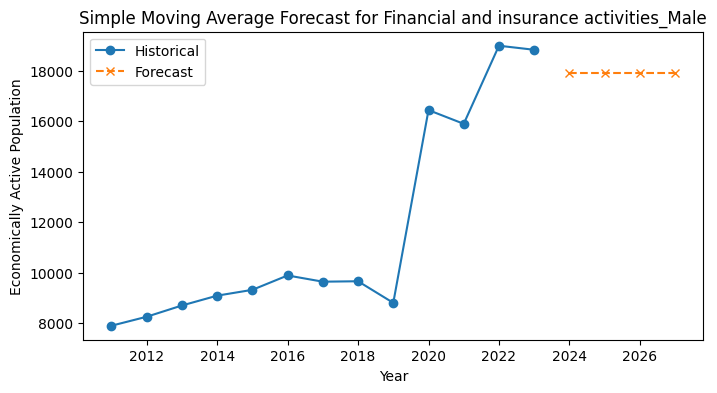

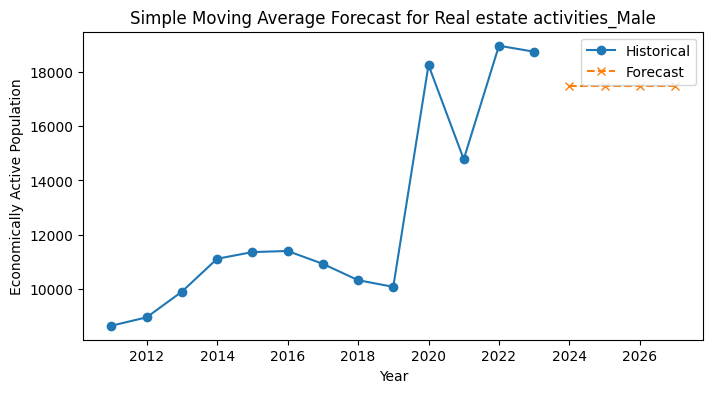

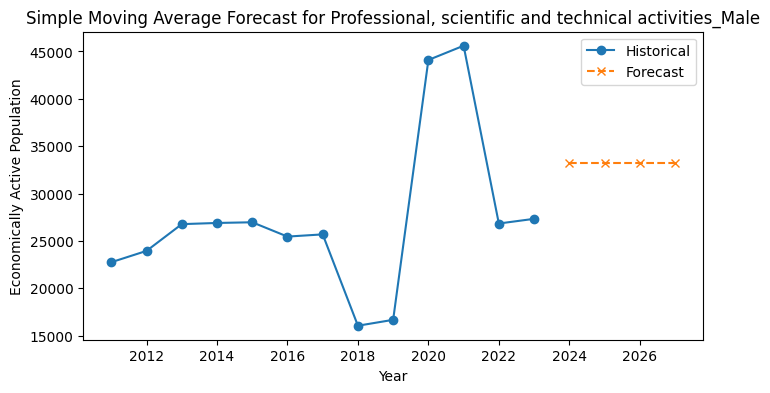

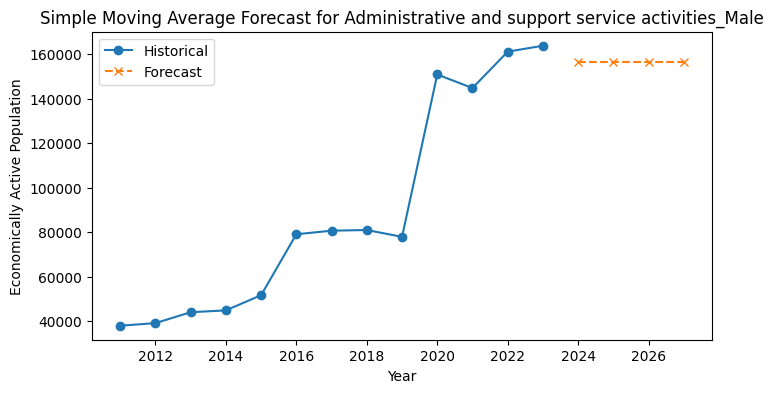

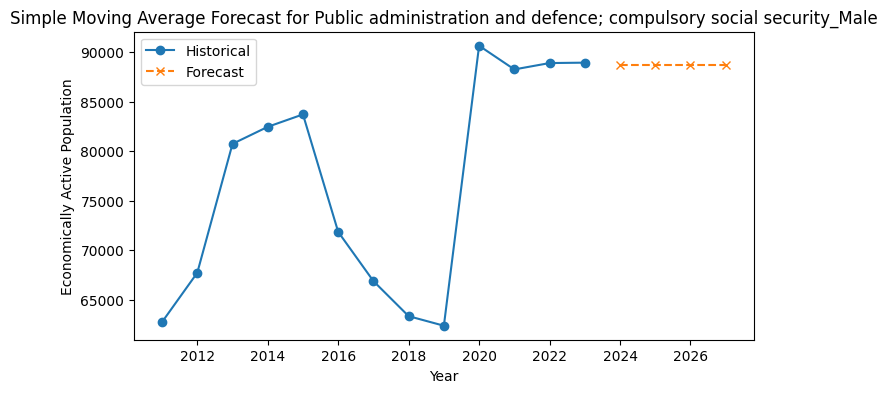

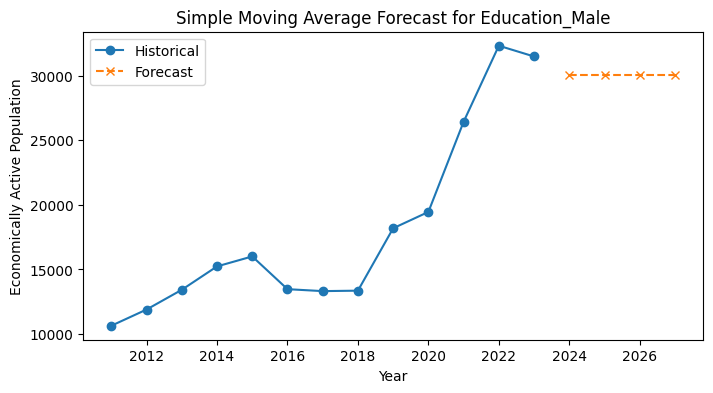

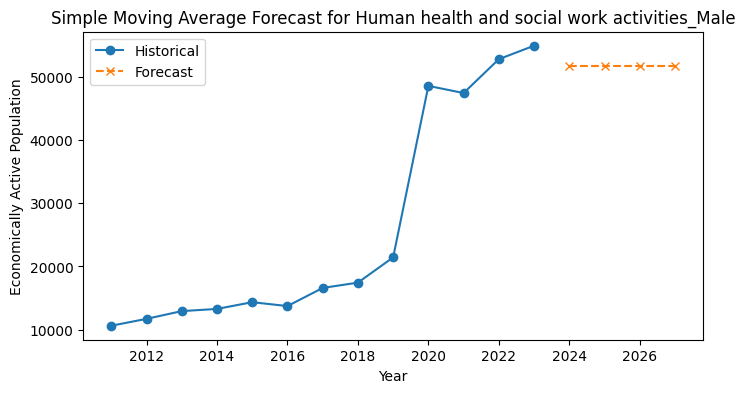

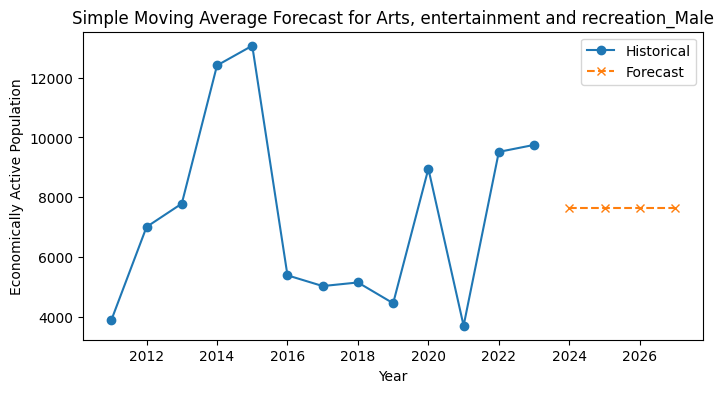

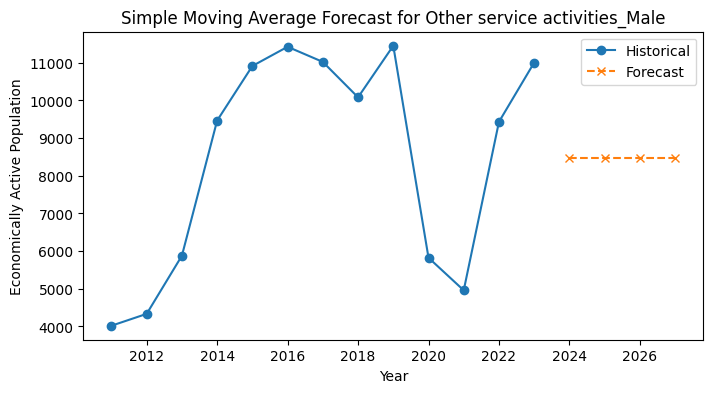

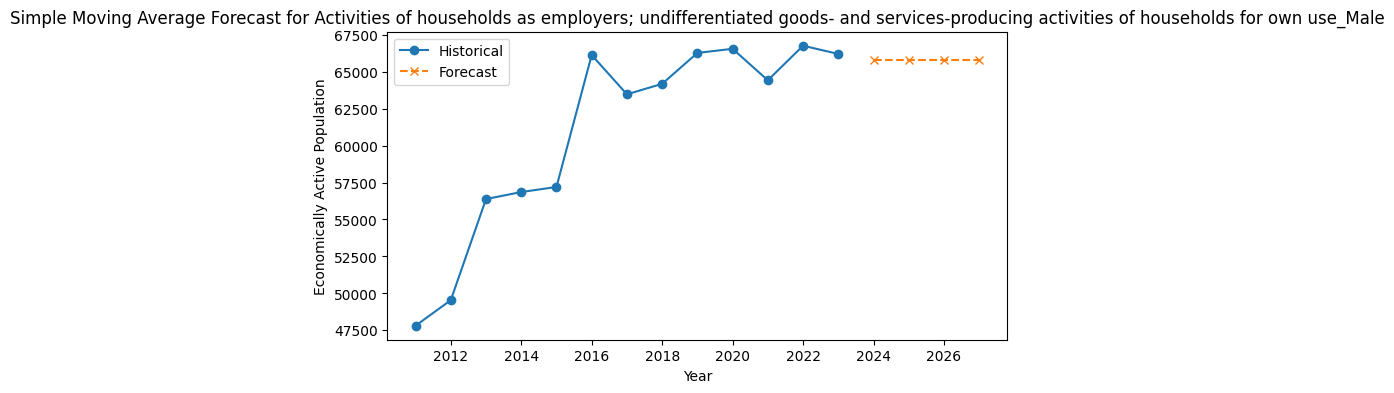

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# ================================================
# 📊 1. Load Historical Dataset
# ================================================

# Load your CSV
df = pd.read_csv("Aggregated_labour_education (2011-2023).csv")

# Combine 'Economic activity' and 'Gender' into 'sector_and_gender'
df['sector_and_gender'] = df['Economic activity'] + '_' + df['Gender']

# Rename 'Year' to 'timestamp' and convert to datetime
df = df.rename(columns={'Year': 'timestamp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y')

# View DataFrame
print("Loaded Data:")
print(df.head())

# ================================================
# ⚙️ 2. Simple Moving Average (SMA) Forecasting
# ================================================

# Initialize list to hold predictions
predictions = []

# Define moving average window
ma_window = 3  # You can adjust this

# Forecast next 4 years for each sector_and_gender
future_years = 4

for group in df['sector_and_gender'].unique():
    group_df = df[df['sector_and_gender'] == group].copy()
    group_df = group_df.sort_values('timestamp')

    # Calculate moving average of the target
    group_df['SMA_Population'] = group_df['Economically active population'].rolling(window=ma_window, min_periods=1).mean()

    # Get the last year from the historical data
    last_year = group_df['timestamp'].dt.year.max()
    last_population = group_df['SMA_Population'].iloc[-1]

    # Forecast for next 4 years using last moving average
    for i in range(1, future_years + 1):
        predictions.append({
            'sector_and_gender': group,
            'Year': last_year + i,
            'Predicted Economically Active Population': last_population
        })

# ================================================
# 📁 3. Save Predictions to CSV
# ================================================

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions)

# Save to CSV
# pred_df.to_csv("prediction.csv", index=False)

print("\n✅ Predictions saved to 'prediction.csv'!")

# ================================================
# 📊 4. Plot Predictions vs Historical (Optional)
# ================================================

for group in df['sector_and_gender'].unique():
    # Historical data
    historical_df = df[df['sector_and_gender'] == group]
    historical_years = historical_df['timestamp'].dt.year
    historical_population = historical_df['Economically active population']

    # Predicted data
    pred_group_df = pred_df[pred_df['sector_and_gender'] == group]
    pred_years = pred_group_df['Year']
    pred_population = pred_group_df['Predicted Economically Active Population']

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(historical_years, historical_population, label='Historical', marker='o')
    plt.plot(pred_years, pred_population, label='Forecast', marker='x', linestyle='--')
    plt.title(f'Simple Moving Average Forecast for {group}')
    plt.xlabel('Year')
    plt.ylabel('Economically Active Population')
    plt.legend()
    plt.show()


### wage

Loaded Data:
   timestamp                                  Economic activity  Gender  \
0 2011-01-01                  Agriculture, forestry and fishing  Female   
1 2011-01-01                               Mining and quarrying  Female   
2 2011-01-01                                      Manufacturing  Female   
3 2011-01-01  Electricity, gas, steam and air conditioning s...  Female   
4 2011-01-01  Water supply; sewerage, waste management and r...  Female   

   Economically active population  Monthly average wage  \
0                              46                  2765   
1                            2487                 18237   
2                             600                 10217   
3                             390                 13807   
4                               0                     0   

   Paid employment workers  Sector GDP  Bachelors  Diploma  Master  Doctorate  \
0                       46       590.0        0.0      0.0     0.0        0.0   
1                  

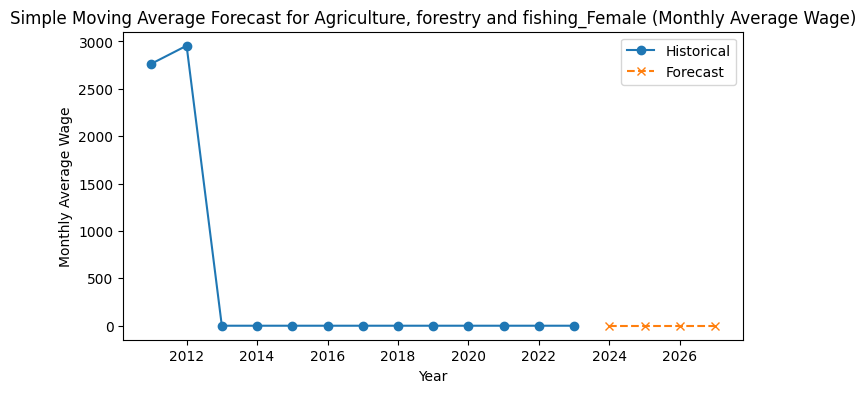

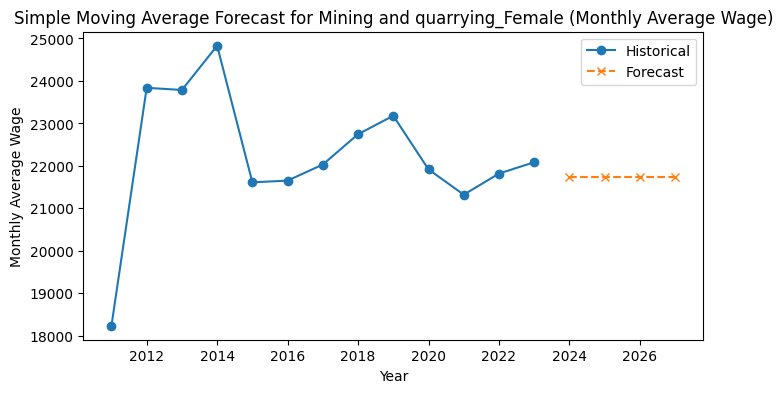

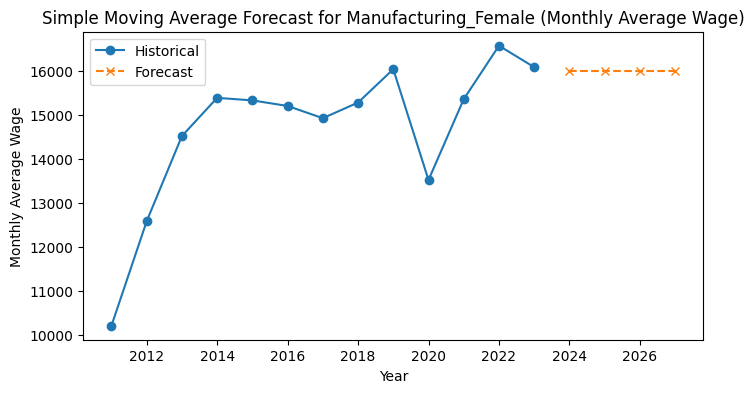

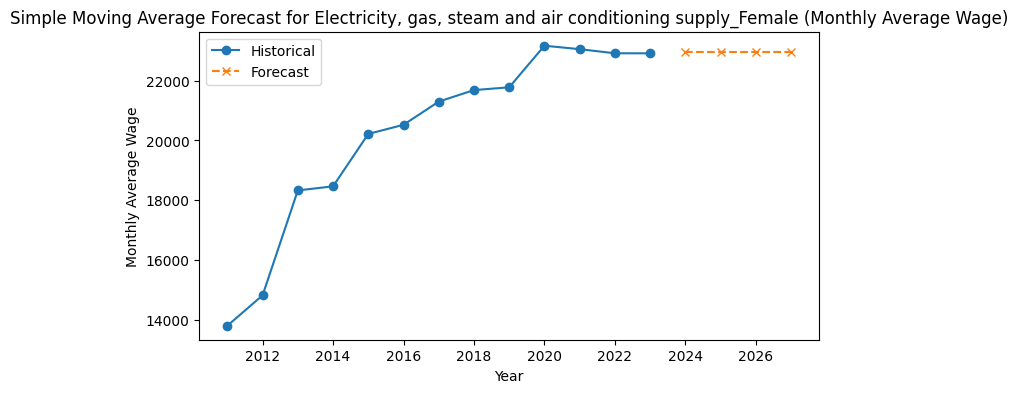

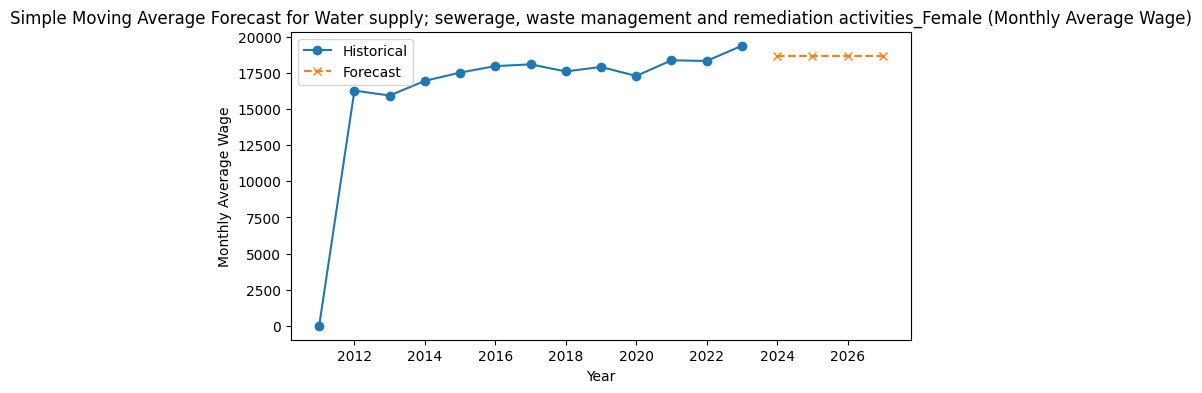

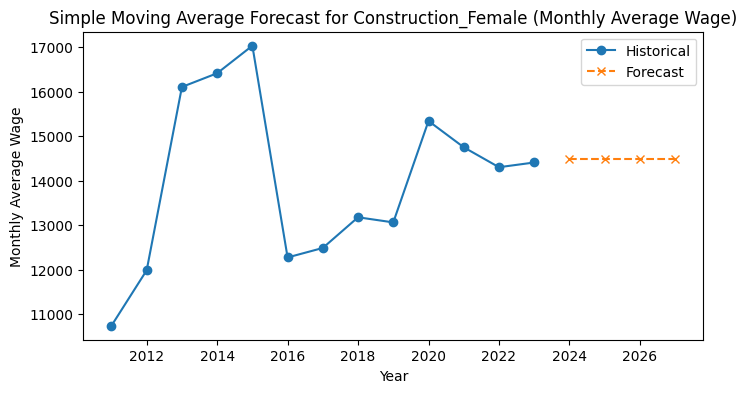

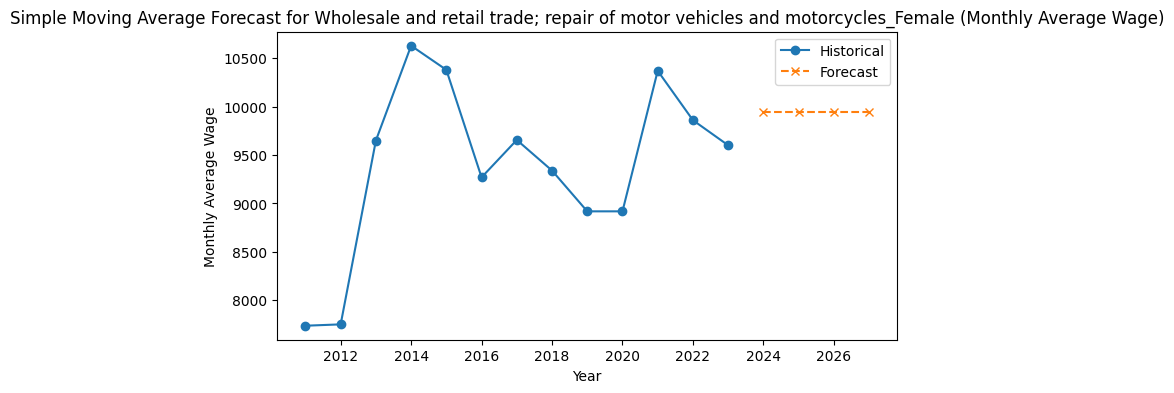

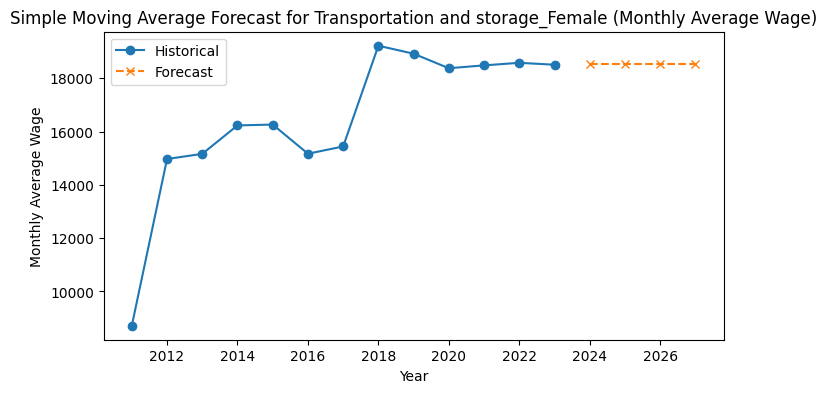

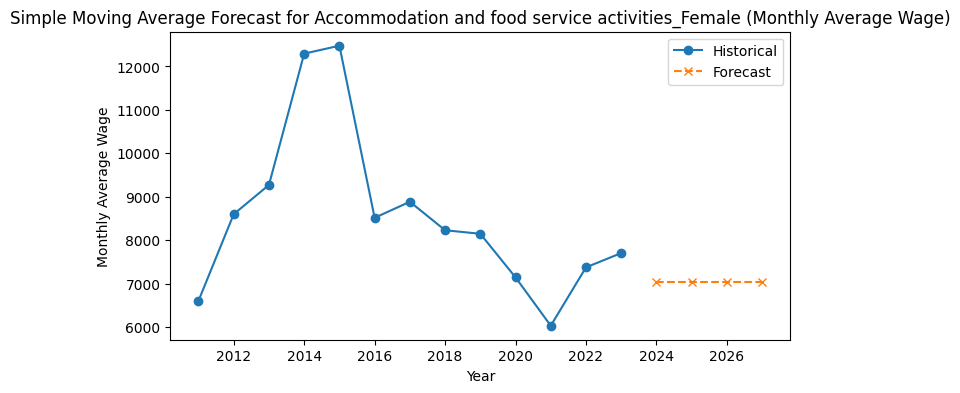

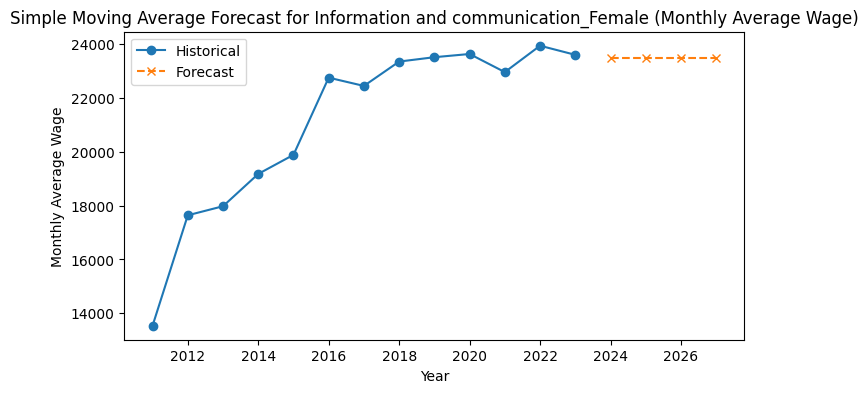

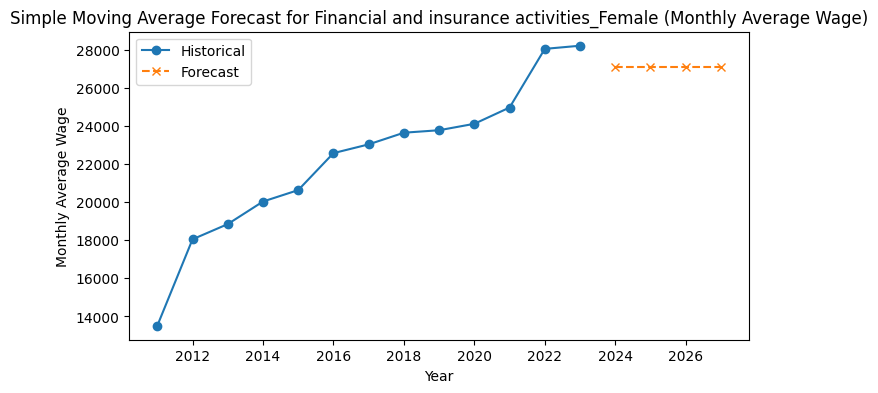

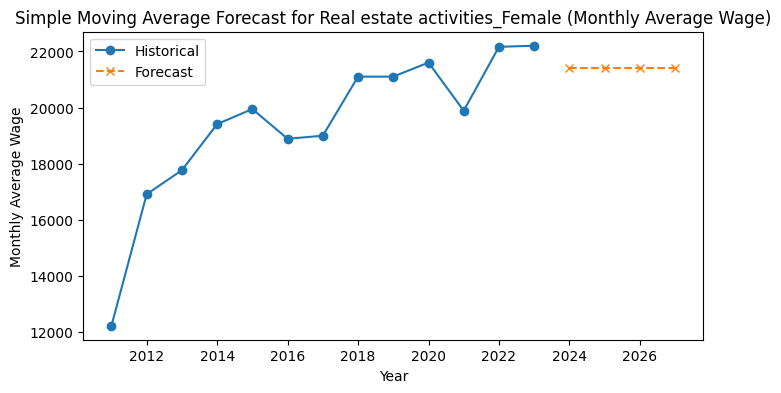

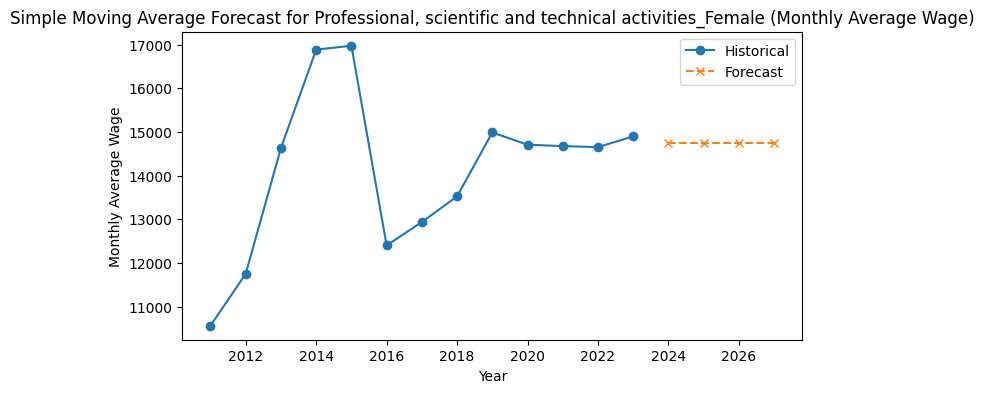

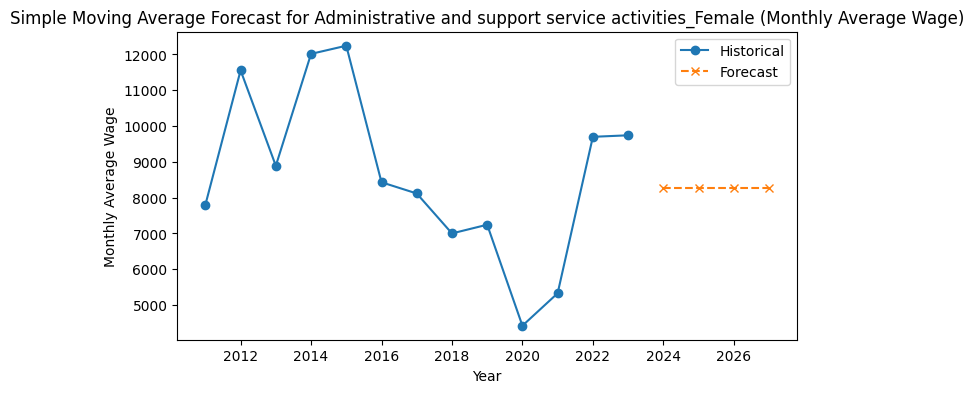

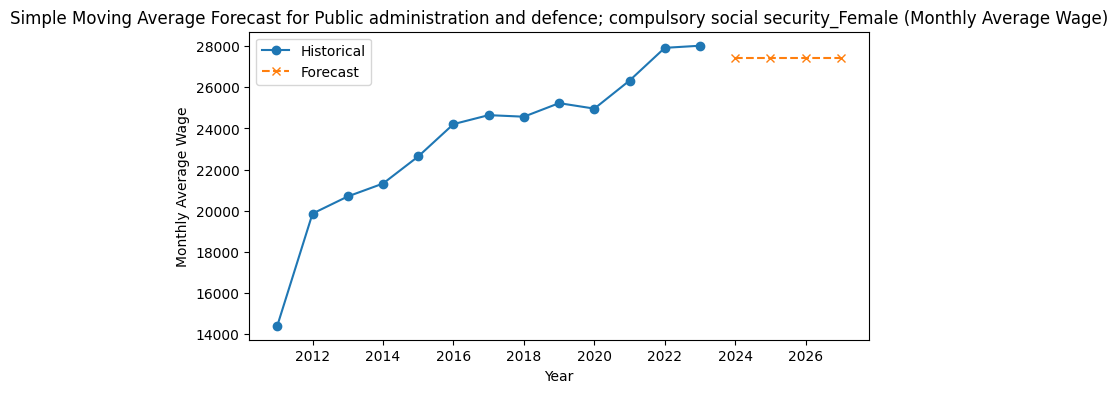

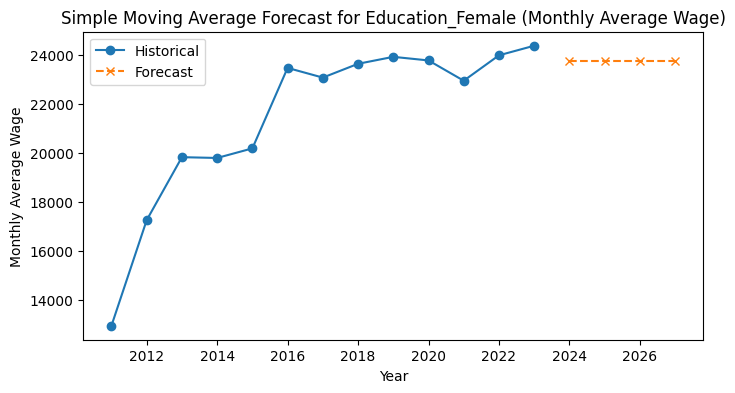

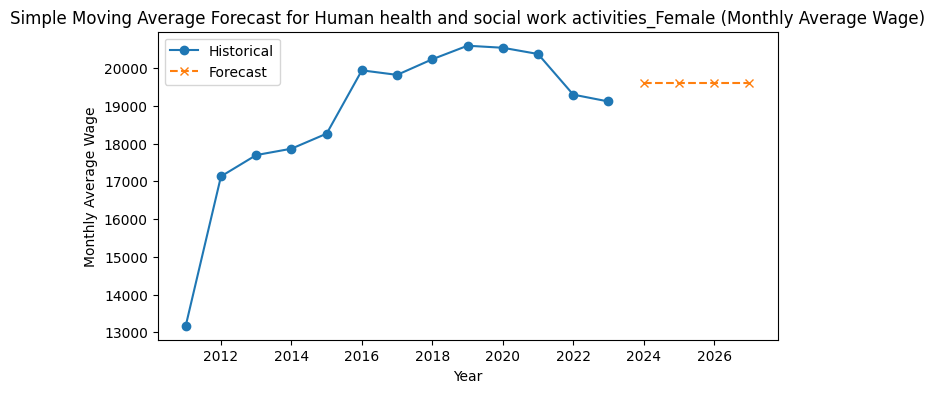

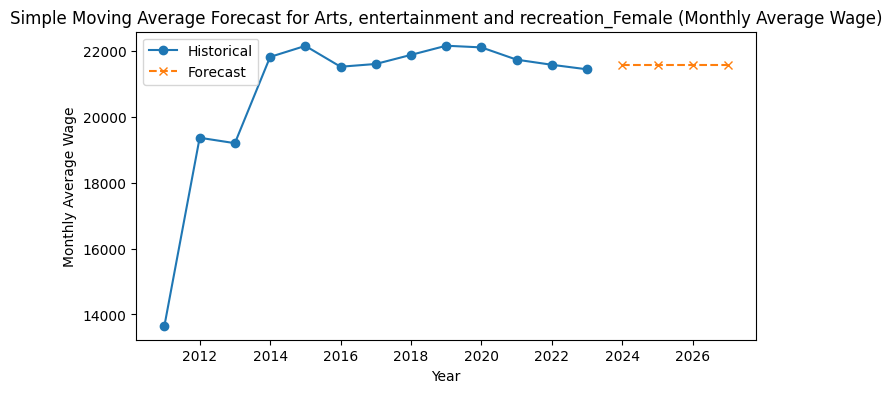

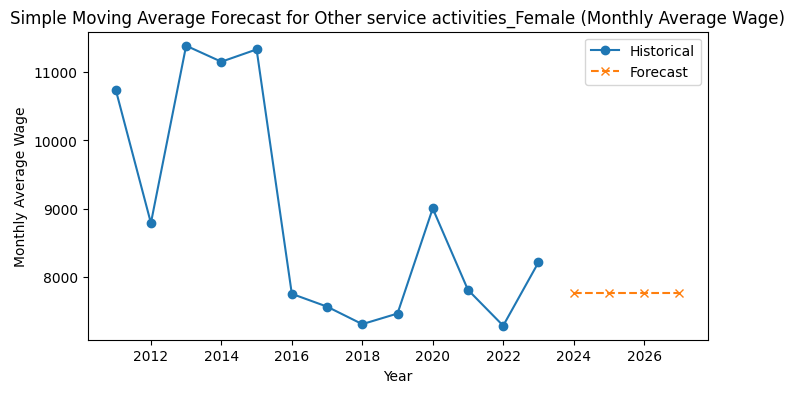

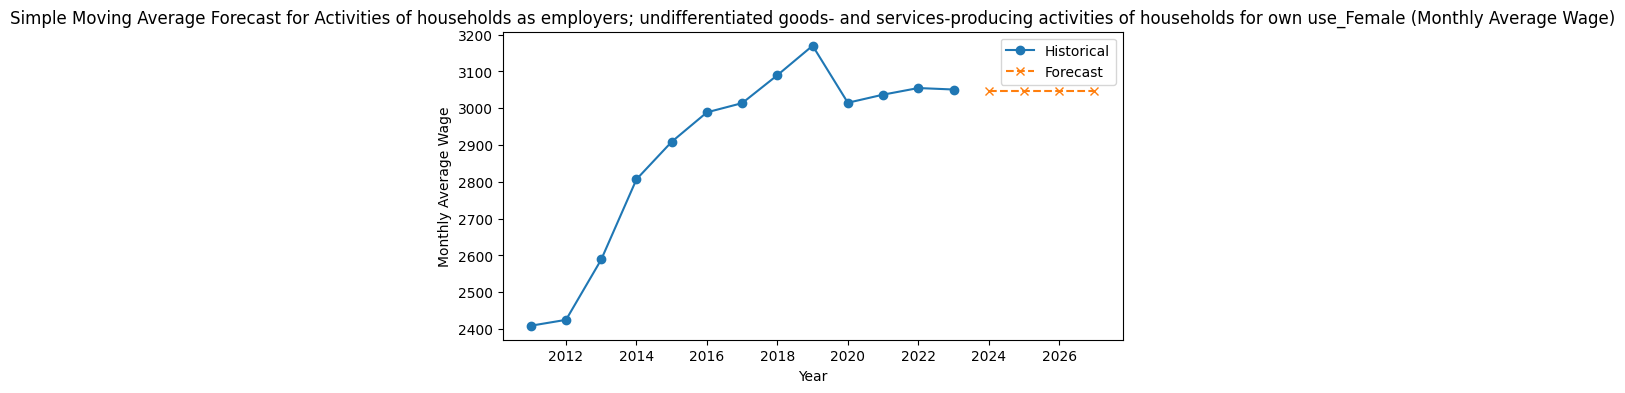

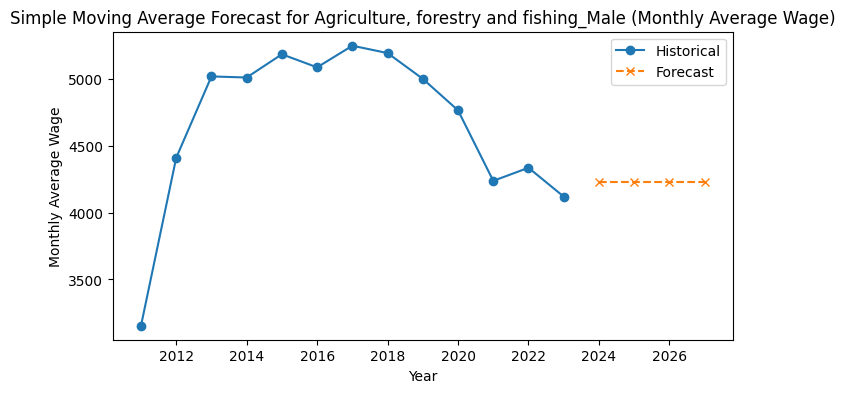

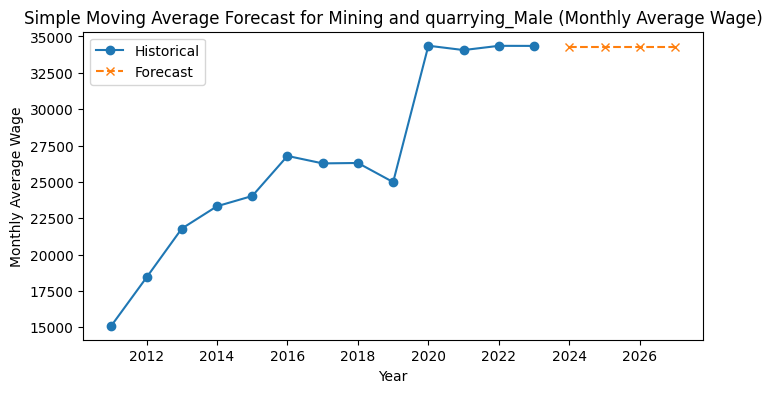

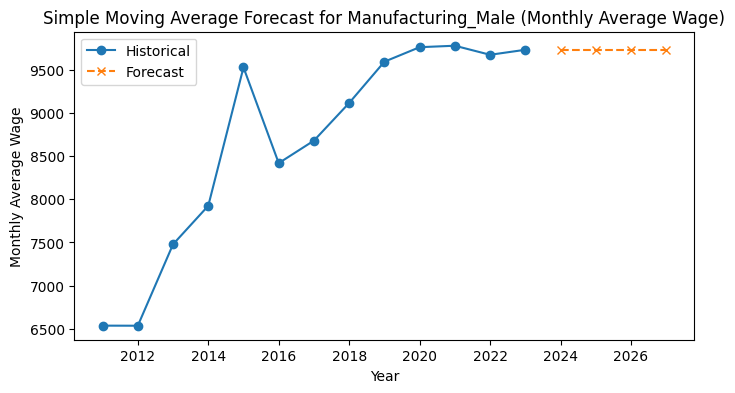

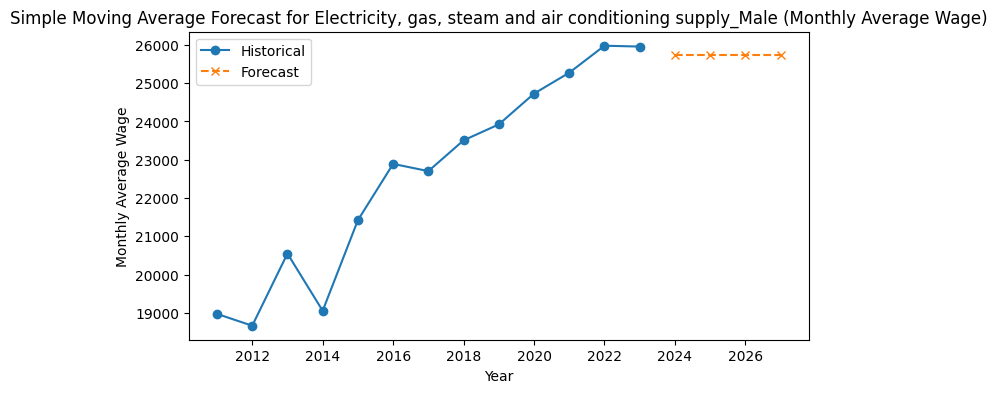

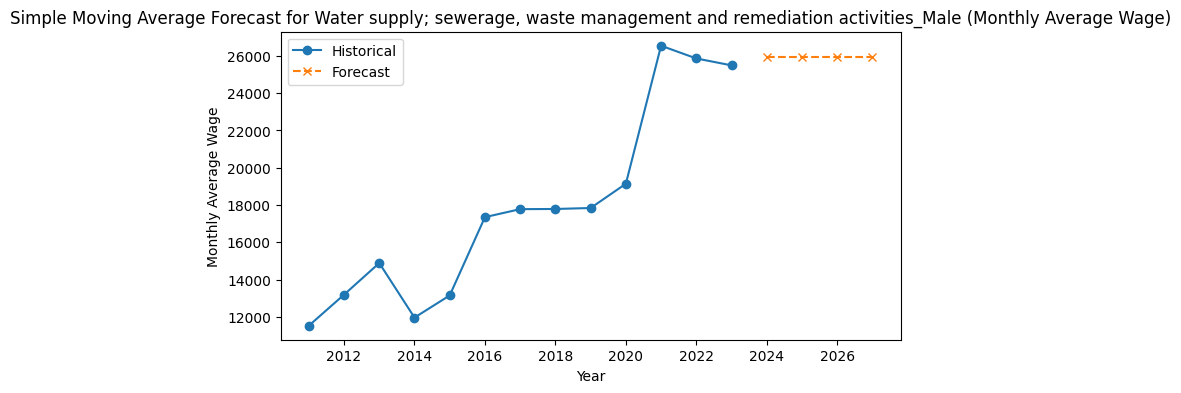

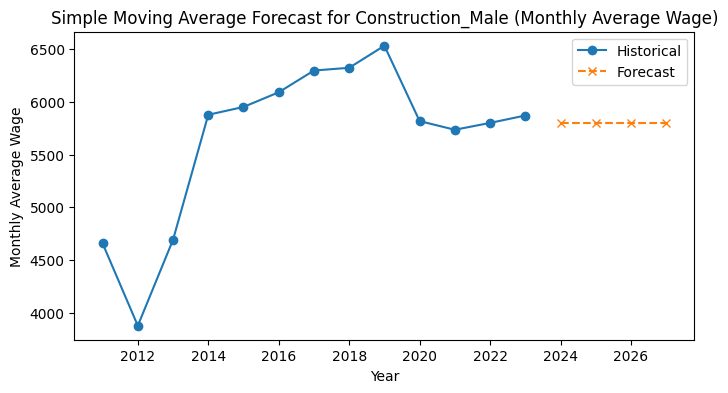

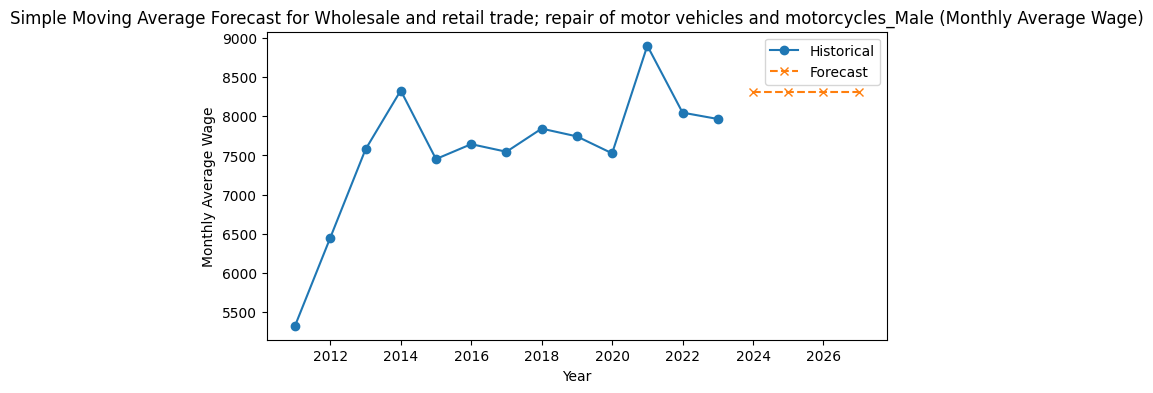

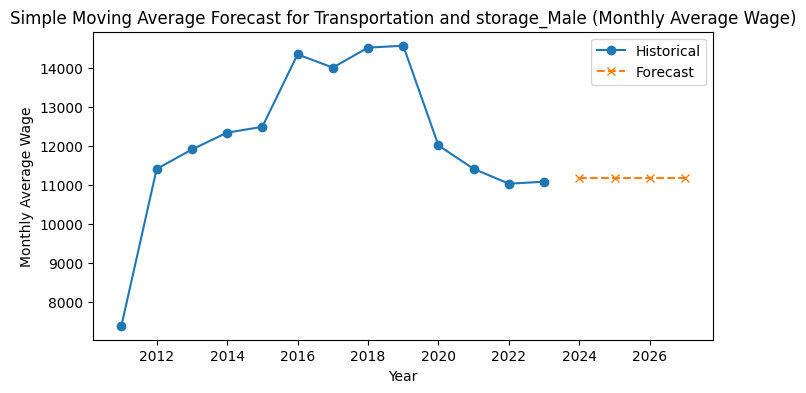

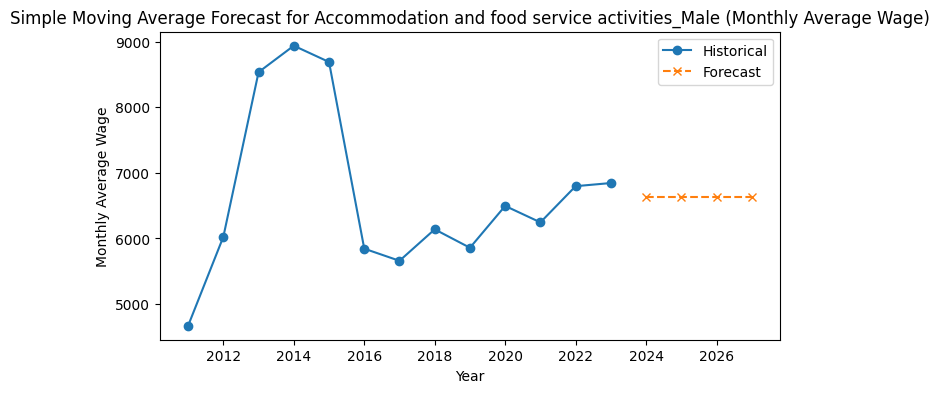

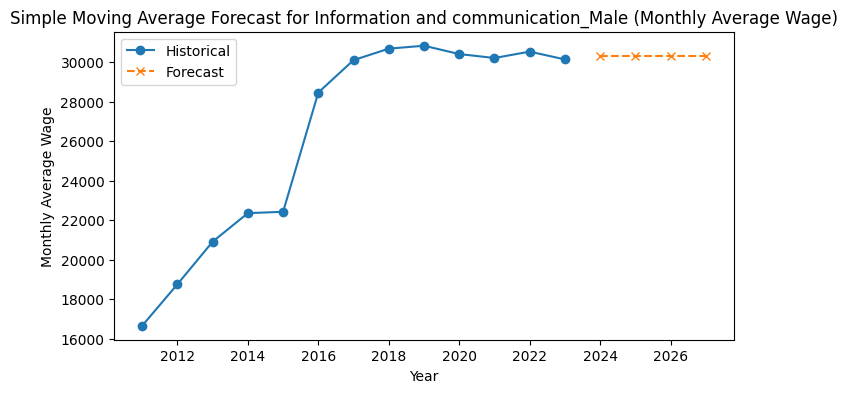

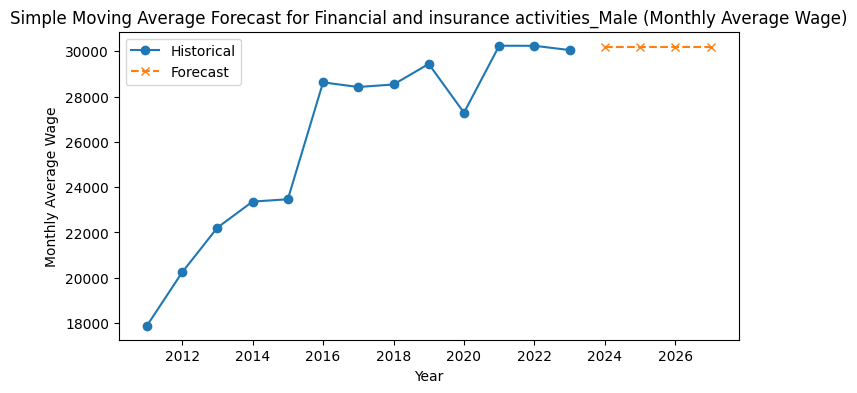

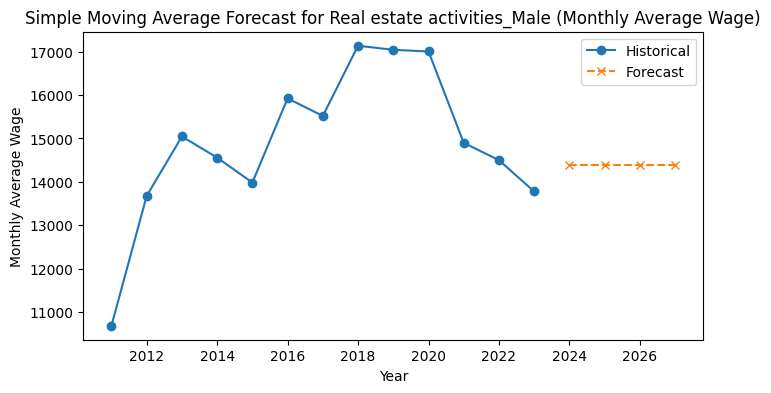

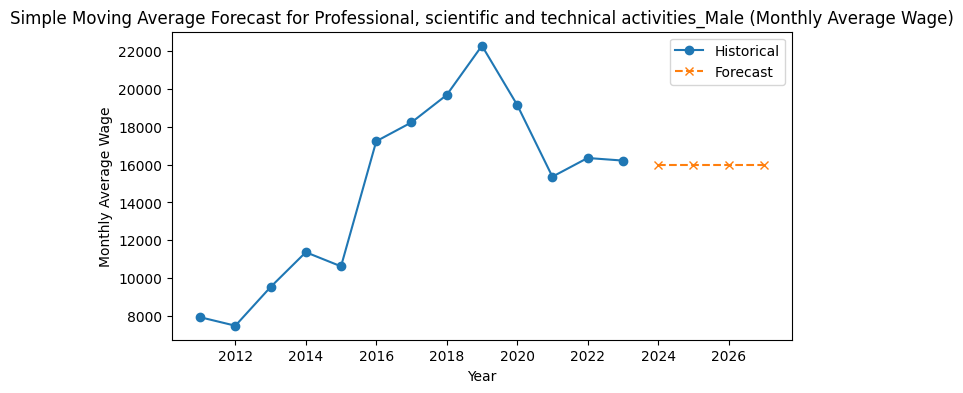

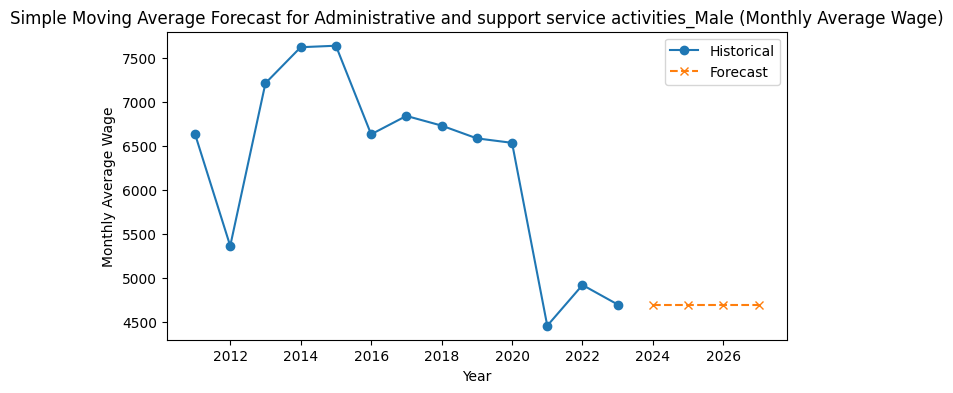

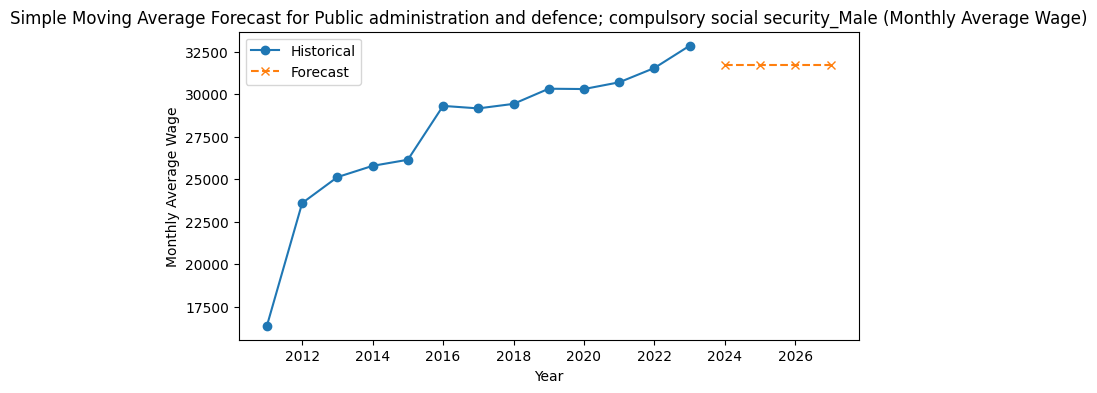

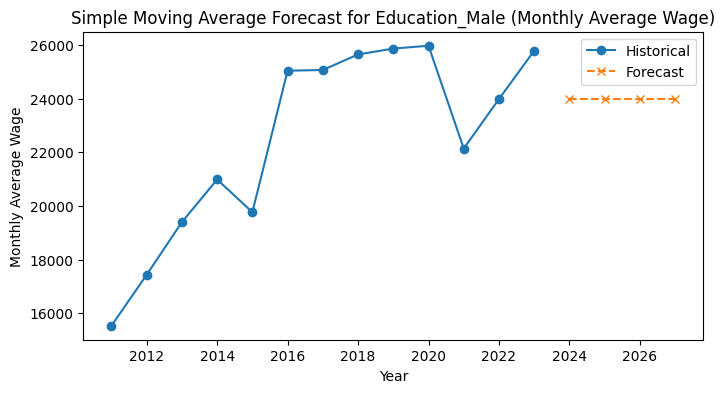

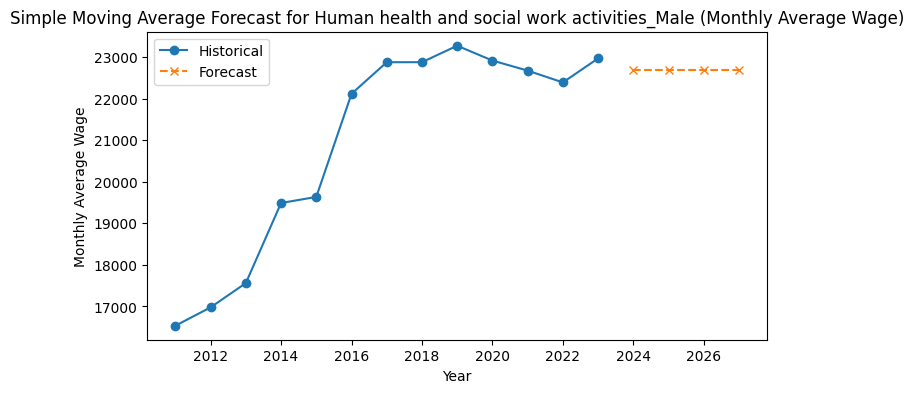

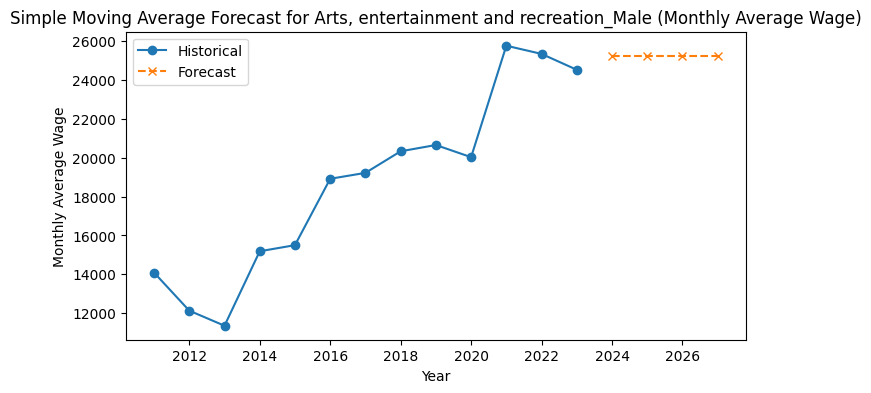

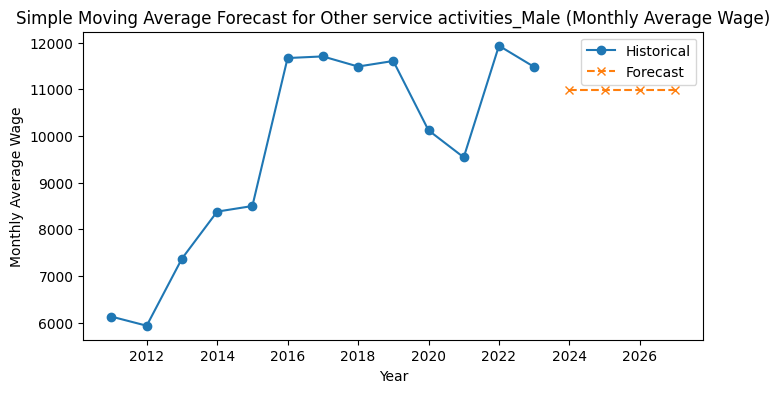

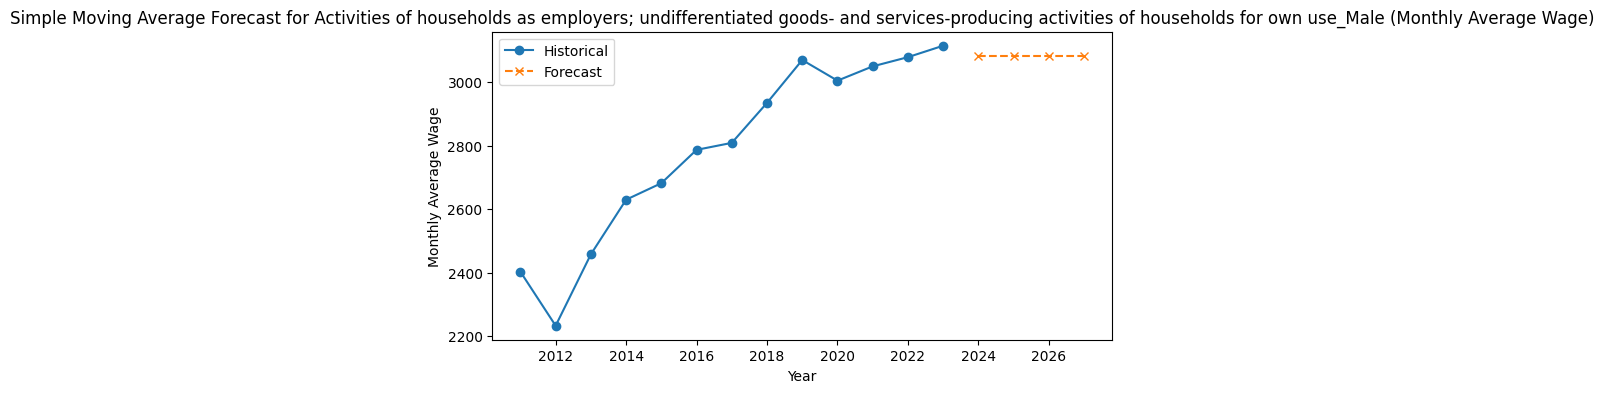

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# ================================================
# 📊 1. Load Historical Dataset
# ================================================

# Load your CSV
df = pd.read_csv("Aggregated_labour_education (2011-2023).csv")

# Combine 'Economic activity' and 'Gender' into 'sector_and_gender'
df['sector_and_gender'] = df['Economic activity'] + '_' + df['Gender']

# Rename 'Year' to 'timestamp' and convert to datetime
df = df.rename(columns={'Year': 'timestamp'})
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y')

# View DataFrame
print("Loaded Data:")
print(df.head())

# ================================================
# ⚙️ 2. Simple Moving Average (SMA) Forecasting
# ================================================

# Initialize list to hold predictions
predictions = []

# Define moving average window
ma_window = 3  # You can adjust this

# Forecast next 4 years for each sector_and_gender
future_years = 4

for group in df['sector_and_gender'].unique():
    group_df = df[df['sector_and_gender'] == group].copy()
    group_df = group_df.sort_values('timestamp')

    # Calculate moving average of the target ('Monthly average wage')
    group_df['SMA_Wage'] = group_df['Monthly average wage'].rolling(window=ma_window, min_periods=1).mean()

    # Get the last year from the historical data
    last_year = group_df['timestamp'].dt.year.max()
    last_wage = group_df['SMA_Wage'].iloc[-1]

    # Forecast for next 4 years using last moving average
    for i in range(1, future_years + 1):
        predictions.append({
            'sector_and_gender': group,
            'Year': last_year + i,
            'Predicted Monthly Average Wage': last_wage
        })

# ================================================
# 📁 3. Save Predictions to CSV
# ================================================

# Convert predictions to DataFrame
pred_df = pd.DataFrame(predictions)

# Save to CSV
pred_df.to_csv("wage prediction.csv", index=False)

print("\n✅ Predictions saved to 'prediction.csv'!")

# ================================================
# 📊 4. Plot Predictions vs Historical (Optional)
# ================================================

for group in df['sector_and_gender'].unique():
    # Historical data
    historical_df = df[df['sector_and_gender'] == group]
    historical_years = historical_df['timestamp'].dt.year
    historical_wage = historical_df['Monthly average wage']

    # Predicted data
    pred_group_df = pred_df[pred_df['sector_and_gender'] == group]
    pred_years = pred_group_df['Year']
    pred_wage = pred_group_df['Predicted Monthly Average Wage']

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(historical_years, historical_wage, label='Historical', marker='o')
    plt.plot(pred_years, pred_wage, label='Forecast', marker='x', linestyle='--')
    plt.title(f'Simple Moving Average Forecast for {group} (Monthly Average Wage)')
    plt.xlabel('Year')
    plt.ylabel('Monthly Average Wage')
    plt.legend()
    plt.show()


# Reformating prediciton

## wage prediction

In [ ]:
import pandas as pd

# Input data
df = pd.read_csv("wage prediction.csv")

# Split 'sector_and_gender' into 'Economic activity' and 'Gender'
df[['Economic activity', 'Gender']] = df['sector_and_gender'].str.rsplit('_', n=1, expand=True)

# Reorder and rename columns
df["Economically active population"] = 0
df = df[['Year', 'Economic activity', 'Gender', "Economically active population", 'Predicted Monthly Average Wage']]
df.rename(columns={'Predicted Monthly Average Wage': 'Monthly average wage'}, inplace=True)

print(df.head())

df.to_csv("wage prediction formatted.csv", index=False)
print("\n✅ Predictions saved to 'wage prediction formatted.csv'!")


   Year                  Economic activity Gender  \
0  2024  Agriculture, forestry and fishing      F   
1  2025  Agriculture, forestry and fishing      F   
2  2026  Agriculture, forestry and fishing      F   
3  2027  Agriculture, forestry and fishing      F   
4  2024               Mining and quarrying      F   

   Economically active population  Monthly average wage  
0                               0              0.000000  
1                               0              0.000000  
2                               0              0.000000  
3                               0              0.000000  
4                               0          21742.333333  

✅ Predictions saved to 'wage prediction formatted.csv'!


### wage forecast

In [ ]:
# Create DataFrame
df = pd.read_csv("wage_forecast_2024_2027.csv")

# Split 'item_id' into 'Economic activity' and 'Gender'
df[['Economic activity', 'Gender']] = df['item_id'].str.rsplit('_', n=1, expand=True)

df['Year'] = pd.to_datetime(df['timestamp']).dt.year
df["Economically active population"] = 0
df.rename(columns={'mean': 'Monthly average wage'}, inplace=True)

# Select and reorder columns
df = df[['Year', 'Economic activity', 'Gender', "Economically active population",'Monthly average wage']]
df.to_csv("wage prediction formatted.csv", index=False)
print(df.head())

   Year                  Economic activity Gender  \
0  2024  Agriculture, forestry and fishing      F   
1  2025  Agriculture, forestry and fishing      F   
2  2026  Agriculture, forestry and fishing      F   
3  2027  Agriculture, forestry and fishing      F   
4  2024               Mining and quarrying      F   

   Economically active population  Monthly average wage  
0                               0             47.430974  
1                               0             56.113129  
2                               0             11.897148  
3                               0             35.501929  
4                               0          22613.651790  
